# Capstone Project

In [1]:
# =============================
# Kaggle download + load
# Steam is game-level with EXACT review aggregates via DuckDB
# Keeps only games present in BOTH games.csv and recommendations.csv
# =============================
import os
import time
import pandas as pd
import kagglehub
import duckdb


# -----------------------------
# Download (KaggleHub)
# -----------------------------
def download_kaggle_dataset(dataset_id):
    print(f"download: {dataset_id}")
    start_time = time.perf_counter()

    try:
        folder_path = kagglehub.dataset_download(dataset_id)
        seconds = round(time.perf_counter() - start_time, 3)
        print(f"download: done -> {folder_path} ({seconds} sec)")
        return folder_path
    except Exception as e:
        seconds = round(time.perf_counter() - start_time, 3)
        print(f"download: failed ({seconds} sec) -> {str(e)}")
        return None


# -----------------------------
# Small file helpers
# -----------------------------
def read_csv_if_exists(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    if not os.path.exists(file_path):
        return None
    try:
        return pd.read_csv(file_path, low_memory=False)
    except Exception:
        return None


def list_csv_files(folder_path):
    if not folder_path or not os.path.exists(folder_path):
        return []
    file_names = os.listdir(folder_path)
    csv_files = [name for name in file_names if name.lower().endswith(".csv")]
    return sorted(csv_files)


# -----------------------------
# Steam review aggregates (DuckDB, exact)
# -----------------------------
def build_review_aggregates_by_game_duckdb(recommendations_csv_path):
    if not os.path.exists(recommendations_csv_path):
        return pd.DataFrame()

    start_time = time.perf_counter()
    print("steam: duckdb aggregating recommendations.csv (this can take a bit)")

    # DuckDB likes forward slashes in file paths
    safe_path = recommendations_csv_path.replace("\\", "/")

    # We cast is_recommended to boolean carefully because CSVs can store True/False as strings
    query = f"""
    SELECT
        app_id,
        COUNT(*) AS review_count,
        SUM(COALESCE(hours, 0)) AS hours_total,
        SUM(COALESCE(helpful, 0)) AS helpful_total,
        SUM(COALESCE(funny, 0)) AS funny_total,
        SUM(
            CASE
                WHEN lower(CAST(is_recommended AS VARCHAR)) IN ('true', '1', 't', 'yes', 'y')
                THEN 1 ELSE 0
            END
        ) AS recommended_total,
        COUNT(DISTINCT user_id) AS unique_users
    FROM read_csv_auto('{safe_path}')
    GROUP BY app_id
    """

    con = duckdb.connect(database=":memory:")
    review_agg = con.execute(query).df()
    con.close()

    review_agg["recommended_ratio"] = review_agg["recommended_total"] / review_agg["review_count"]
    review_agg["hours_mean"] = review_agg["hours_total"] / review_agg["review_count"]
    review_agg["helpful_mean"] = review_agg["helpful_total"] / review_agg["review_count"]
    review_agg["funny_mean"] = review_agg["funny_total"] / review_agg["review_count"]

    seconds = round(time.perf_counter() - start_time, 3)
    print(f"steam: duckdb aggregation done ({seconds} sec)")

    return review_agg


# -----------------------------
# Steam loader (game-level)
# -----------------------------
def load_steam(folder_path):
    if folder_path is None:
        return None

    games = read_csv_if_exists(folder_path, "games.csv")
    if games is None:
        return None

    meta_path = os.path.join(folder_path, "games_metadata.json")
    metadata = None
    if os.path.exists(meta_path):
        try:
            metadata = pd.read_json(meta_path, lines=True)
        except Exception:
            metadata = None

    games_plus = games.copy()
    if metadata is not None and "app_id" in games_plus.columns and "app_id" in metadata.columns:
        games_plus = games_plus.merge(metadata, on="app_id", how="left", suffixes=("", "_meta"))

    recommendations_path = os.path.join(folder_path, "recommendations.csv")
    if not os.path.exists(recommendations_path):
        return games_plus

    review_agg = build_review_aggregates_by_game_duckdb(recommendations_path)

    # Keep only games that exist in BOTH tables
    steam_game_df = games_plus.merge(review_agg, on="app_id", how="inner")

    return steam_game_df


# -----------------------------
# Olist loader (unchanged)
# -----------------------------
def load_olist(folder_path):
    if folder_path is None:
        return None

    orders = read_csv_if_exists(folder_path, "olist_orders_dataset.csv")
    customers = read_csv_if_exists(folder_path, "olist_customers_dataset.csv")
    items = read_csv_if_exists(folder_path, "olist_order_items_dataset.csv")
    products = read_csv_if_exists(folder_path, "olist_products_dataset.csv")
    sellers = read_csv_if_exists(folder_path, "olist_sellers_dataset.csv")

    if any(x is None for x in [orders, customers, items, products, sellers]):
        return None

    cat_trans = read_csv_if_exists(folder_path, "product_category_name_translation.csv")
    products_en = products
    if cat_trans is not None and "product_category_name" in products.columns:
        products_en = products.merge(cat_trans, on="product_category_name", how="left")

    geolocation = read_csv_if_exists(folder_path, "olist_geolocation_dataset.csv")
    customers_geo = customers
    if geolocation is not None:
        geo_zip = (
            geolocation.groupby("geolocation_zip_code_prefix", as_index=False)
            .agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
            )
        )
        customers_geo = customers.merge(
            geo_zip,
            left_on="customer_zip_code_prefix",
            right_on="geolocation_zip_code_prefix",
            how="left",
        ).drop(columns=["geolocation_zip_code_prefix"], errors="ignore")

    payments = read_csv_if_exists(folder_path, "olist_order_payments_dataset.csv")
    payments_agg = None
    if payments is not None:
        payments_agg = (
            payments.groupby("order_id", as_index=False)
            .agg(
                payment_value_total=("payment_value", "sum"),
                payment_installments_max=("payment_installments", "max"),
            )
        )

    reviews = read_csv_if_exists(folder_path, "olist_order_reviews_dataset.csv")
    product_stats = None
    if reviews is not None:
        product_reviews = (
            items[["order_id", "product_id"]]
            .merge(reviews[["order_id", "review_score"]], on="order_id", how="inner")
            .drop_duplicates(["order_id", "product_id"])
        )
        product_stats = product_reviews.groupby("product_id", as_index=False).agg(
            review_score_mean_product=("review_score", "mean")
        )

    items_ext = (
        items.merge(products_en, on="product_id", how="left")
        .merge(sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    olist_df = orders.merge(customers_geo, on="customer_id", how="left").merge(items_ext, on="order_id", how="left")

    if payments_agg is not None:
        olist_df = olist_df.merge(payments_agg, on="order_id", how="left")

    if product_stats is not None:
        olist_df = olist_df.merge(product_stats, on="product_id", how="left")

    return olist_df


# -----------------------------
# VG2019 loader (unchanged)
# -----------------------------
def load_vg2019(folder_path):
    if folder_path is None:
        return None

    csv_files = list_csv_files(folder_path)
    if not csv_files:
        return None

    chosen_file = None
    for file_name in csv_files:
        if "vgsales" in file_name.lower():
            chosen_file = file_name
            break

    if chosen_file is None:
        chosen_file = csv_files[0]

    return read_csv_if_exists(folder_path, chosen_file)


# =============================
# Download + load all 3
# =============================
steam_folder = download_kaggle_dataset("antonkozyriev/game-recommendations-on-steam")
olist_folder = download_kaggle_dataset("olistbr/brazilian-ecommerce")
vg2019_folder = download_kaggle_dataset("ashaheedq/video-games-sales-2019")

steam_df = load_steam(steam_folder)
olist_df = load_olist(olist_folder)
sales_df = load_vg2019(vg2019_folder)

print("steam:", None if steam_df is None else steam_df.shape)
print("olist:", None if olist_df is None else olist_df.shape)
print("sales:", None if sales_df is None else sales_df.shape)


download: antonkozyriev/game-recommendations-on-steam
download: done -> /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 (0.257 sec)
download: olistbr/brazilian-ecommerce
download: done -> /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 (0.198 sec)
download: ashaheedq/video-games-sales-2019
download: done -> /Users/chandlercampbell/.cache/kagglehub/datasets/ashaheedq/video-games-sales-2019/versions/2 (0.177 sec)
steam: duckdb aggregating recommendations.csv (this can take a bit)
steam: duckdb aggregation done (1.023 sec)
steam: (37610, 25)
olist: (113425, 35)
sales: (55792, 16)


In [2]:
import pandas as pd

pd.set_option("display.max_columns", None)
steam_df


,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags,review_count,hours_total,helpful_total,funny_total,recommended_total,unique_users,recommended_ratio,hours_mean,helpful_mean,funny_mean
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre...",1686,31979.9,9091.0,1032.0,1426.0,1686,0.845789,18.967912,5.392052,0.612100
1,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St...",6943,141729.5,9961.0,3127.0,6308.0,6943,0.908541,20.413294,1.434682,0.450382
2,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P...",877,9451.1,5945.0,715.0,549.0,877,0.625998,10.776625,6.778791,0.815279
3,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra...",4850,197015.2,12275.0,3387.0,4295.0,4850,0.885567,40.621691,2.530928,0.698351
4,250180,METAL SLUG 3,2015-09-14,True,False,False,Very Positive,90,5579,7.99,7.99,0.0,True,"“METAL SLUG 3”, the masterpiece in SNK’s emble...","[Arcade, Classic, Action, Co-op, Side Scroller...",5385,54617.8,14221.0,2125.0,4814.0,5385,0.893965,10.142581,2.640854,0.394615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37605,632470,Disco Elysium - The Final Cut,2019-10-15,True,True,False,Very Positive,93,75060,40.00,0.00,0.0,True,,[],29841,1183623.6,153260.0,32870.0,28129.0,29841,0.942629,39.664341,5.135887,1.101505
37606,1599660,Sackboy™: A Big Adventure,2022-10-27,True,False,False,Very Positive,85,1154,60.00,0.00,0.0,True,,[],884,13352.8,12721.0,960.0,797.0,884,0.901584,15.104977,14.390271,1.085973
37607,250900,The Binding of Isaac: Rebirth,2014-11-04,True,True,True,Overwhelmingly Positive,97,225815,15.00,0.00,0.0,True,,[],114002,33914457.8,154886.0,82131.0,111313.0,114002,0.976413,297.490025,1.358625,0.720435
37608,920210,LEGO® Star Wars™: The Skywalker Saga,2022-04-05,True,False,False,Very Positive,91,30937,50.00,0.00,0.0,True,,[],18605,791612.4,112302.0,32314.0,17054.0,18605,0.916635,42.548369,6.036119,1.736845


In [3]:
olist_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,payment_value_total,payment_installments_max,review_score_mean_product
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350.0,maua,SP,38.71,1.0,4.000000
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.177924,-44.660711,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,31570.0,belo horizonte,SP,141.46,1.0,4.440000
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.745150,-48.514783,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,14840.0,guariba,SP,179.12,3.0,5.000000
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,-5.774190,-35.271143,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop,31842.0,belo horizonte,MG,72.20,1.0,4.250000
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,-23.676370,-46.514627,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0,stationery,8752.0,mogi das cruzes,SP,28.62,1.0,4.258065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,-24.001500,-46.449864,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,bebes,52.0,828.0,4.0,4950.0,40.0,10.0,40.0,baby,17602.0,tupa,SP,195.00,3.0,4.000000
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,-17.898358,-39.373630,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,eletrodomesticos_2,51.0,500.0,2.0,13300.0,32.0,90.0,22.0,home_appliances_2,8290.0,sao paulo,SP,271.01,5.0,3.6666

In [4]:
sales_df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
0,1,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0
1,2,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0
2,3,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0
3,4,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,36.60,NaN,NaN,NaN,NaN,NaN,2017.0
4,5,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,33.09,NaN,NaN,NaN,NaN,NaN,2009.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55787,55788,Indivisible,Role-Playing,NaN,PC,505 Games,Lab Zero Games,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
55788,55789,Lost Ember,Adventure,RP,PC,Mooneye Studios,Mooneye Studios,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
55789,55790,Lost Ember,Adventure,RP,PS4,Mooneye Studios,Mooneye Studios,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
55790,55791,Lost Ember,Adventure,RP,XOne,Mooneye Studios,Mooneye Studios,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.0


In [5]:
"""
Exploratory Data Analysis (EDA) Function
A beginner-friendly function to analyze any dataset
"""

import pandas as pd


def explore_dataset(dataframe, dataset_name="My Dataset"):
    """
    Performs a complete exploratory data analysis on a given dataset.
    
    Parameters:
    - dataframe: A pandas DataFrame to analyze
    - dataset_name: A string name for the dataset (optional)
    """
    
    # Create a separator line for visual clarity
    separator_line = "=" * 60
    
    # =========================================================
    # SECTION 1: Dataset Name and Columns
    # =========================================================
    print(separator_line)
    print(f"DATASET NAME: {dataset_name}")
    print(separator_line)
    
    # Get the list of all column names
    column_names = dataframe.columns.tolist()
    number_of_columns = len(column_names)
    
    print(f"\nCOLUMNS ({number_of_columns} total):")
    print("-" * 40)
    for index, column in enumerate(column_names, start=1):
        print(f"  {index}. {column}")
    
    # =========================================================
    # SECTION 2: Basic Dataset Information
    # =========================================================
    print(f"\n{separator_line}")
    print("BASIC INFORMATION")
    print(separator_line)
    
    number_of_rows = len(dataframe)
    print(f"Number of rows: {number_of_rows}")
    print(f"Number of columns: {number_of_columns}")
    
    # Calculate memory usage in a readable format
    memory_usage_bytes = dataframe.memory_usage(deep=True).sum()
    memory_usage_megabytes = round(memory_usage_bytes / (1024 * 1024), 2)
    print(f"Memory usage: {memory_usage_megabytes} MB")
    
    # =========================================================
    # SECTION 3: Data Types
    # =========================================================
    print(f"\n{separator_line}")
    print("DATA TYPES")
    print(separator_line)
    
    # Count how many columns of each data type
    data_type_counts = dataframe.dtypes.value_counts()
    print("\nColumn types summary:")
    for data_type, count in data_type_counts.items():
        print(f"  {data_type}: {count} columns")
    
    # Show each column with its data type
    print("\nDetailed column types:")
    print("-" * 40)
    for column in column_names:
        column_data_type = dataframe[column].dtype
        print(f"  {column}: {column_data_type}")
    
    # =========================================================
    # SECTION 4: Missing Values Analysis
    # =========================================================
    print(f"\n{separator_line}")
    print("MISSING VALUES ANALYSIS")
    print(separator_line)
    
    # Calculate missing values for each column
    missing_values_count = dataframe.isnull().sum()
    missing_values_percentage = (dataframe.isnull().sum() / number_of_rows) * 100
    
    # Find columns that have missing values
    columns_with_missing = missing_values_count[missing_values_count > 0]
    
    if len(columns_with_missing) == 0:
        print("\nNo missing values found in the dataset!")
    else:
        print(f"\nColumns with missing values ({len(columns_with_missing)} found):")
        print("-" * 40)
        for column in columns_with_missing.index:
            count = missing_values_count[column]
            percentage = round(missing_values_percentage[column], 2)
            print(f"  {column}: {count} missing ({percentage}%)")
    
    # Total missing values
    total_missing = missing_values_count.sum()
    total_cells = number_of_rows * number_of_columns
    total_missing_percentage = round((total_missing / total_cells) * 100, 2)
    print(f"\nTotal missing values: {total_missing} out of {total_cells} cells ({total_missing_percentage}%)")
    
    # =========================================================
    # SECTION 5: Duplicate Rows
    # =========================================================
    print(f"\n{separator_line}")
    print("DUPLICATE ROWS")
    print(separator_line)
    
    # Try to check for duplicates (may fail if columns contain unhashable types like lists)
    try:
        number_of_duplicates = dataframe.duplicated().sum()
        duplicate_percentage = round((number_of_duplicates / number_of_rows) * 100, 2)
        print(f"Duplicate rows: {number_of_duplicates} ({duplicate_percentage}%)")
    except TypeError:
        # This happens when a column contains lists or other unhashable types
        print("Could not check for duplicates (dataset contains unhashable types like lists)")
        
        # Try to identify which columns have unhashable types
        columns_with_lists = []
        for column in column_names:
            # Check if any value in the column is a list
            sample_values = dataframe[column].dropna().head(100)
            for value in sample_values:
                if isinstance(value, (list, dict)):
                    columns_with_lists.append(column)
                    break
        
        if columns_with_lists:
            print(f"Columns with list/dict values: {columns_with_lists}")
    
    # =========================================================
    # SECTION 6: Numeric Columns Statistics
    # =========================================================
    print(f"\n{separator_line}")
    print("NUMERIC COLUMNS STATISTICS")
    print(separator_line)
    
    # Select only numeric columns
    numeric_columns = dataframe.select_dtypes(include=["number"]).columns.tolist()
    
    if len(numeric_columns) == 0:
        print("\nNo numeric columns found in the dataset.")
    else:
        print(f"\nFound {len(numeric_columns)} numeric columns:")
        print("-" * 40)
        
        for column in numeric_columns:
            print(f"\n  Column: {column}")
            
            # Calculate statistics
            minimum_value = dataframe[column].min()
            maximum_value = dataframe[column].max()
            mean_value = round(dataframe[column].mean(), 2)
            median_value = round(dataframe[column].median(), 2)
            standard_deviation = round(dataframe[column].std(), 2)
            
            # Calculate quartiles
            quartile_25 = round(dataframe[column].quantile(0.25), 2)
            quartile_75 = round(dataframe[column].quantile(0.75), 2)
            
            print(f"    Min: {minimum_value}")
            print(f"    Max: {maximum_value}")
            print(f"    Mean: {mean_value}")
            print(f"    Median: {median_value}")
            print(f"    Std Dev: {standard_deviation}")
            print(f"    25th Percentile: {quartile_25}")
            print(f"    75th Percentile: {quartile_75}")
    
    # =========================================================
    # SECTION 7: Categorical Columns Analysis
    # =========================================================
    print(f"\n{separator_line}")
    print("CATEGORICAL COLUMNS ANALYSIS")
    print(separator_line)
    
    # Select non-numeric columns (likely categorical)
    categorical_columns = dataframe.select_dtypes(include=["object", "category"]).columns.tolist()
    
    if len(categorical_columns) == 0:
        print("\nNo categorical columns found in the dataset.")
    else:
        print(f"\nFound {len(categorical_columns)} categorical columns:")
        print("-" * 40)
        
        for column in categorical_columns:
            # Try to analyze the column (may fail if it contains lists)
            try:
                unique_values_count = dataframe[column].nunique()
                most_common_value = dataframe[column].mode().iloc[0] if not dataframe[column].mode().empty else "N/A"
                most_common_count = dataframe[column].value_counts().iloc[0] if unique_values_count > 0 else 0
                
                print(f"\n  Column: {column}")
                print(f"    Unique values: {unique_values_count}")
                print(f"    Most common: '{most_common_value}' (appears {most_common_count} times)")
                
                # Show value counts if there are few unique values
                if unique_values_count <= 10:
                    print(f"    Value distribution:")
                    value_counts = dataframe[column].value_counts()
                    for value, count in value_counts.items():
                        percentage = round((count / number_of_rows) * 100, 2)
                        print(f"      '{value}': {count} ({percentage}%)")
            
            except TypeError:
                # This column contains unhashable types like lists
                print(f"\n  Column: {column}")
                print(f"    Contains unhashable types (lists/dicts) - cannot compute statistics")
                
                # Show sample values instead
                sample_values = dataframe[column].dropna().head(3).tolist()
                print(f"    Sample values: {sample_values}")
    
    # =========================================================
    # SECTION 8: Sample Data Preview
    # =========================================================
    print(f"\n{separator_line}")
    print("SAMPLE DATA PREVIEW")
    print(separator_line)
    
    print("\nFirst 5 rows:")
    print(dataframe.head())
    
    print("\nLast 5 rows:")
    print(dataframe.tail())
    
    # =========================================================
    # END OF ANALYSIS
    # =========================================================
    print(f"\n{separator_line}")
    print("END OF EXPLORATORY DATA ANALYSIS")
    print(separator_line)

In [6]:
explore_dataset(steam_df, dataset_name="Steam Game Reviews Dataset")
explore_dataset(olist_df, dataset_name="Olist Brazilian E-commerce Dataset")
explore_dataset(sales_df, dataset_name="Video Game Sales 2019 Dataset")

DATASET NAME: Steam Game Reviews Dataset

COLUMNS (25 total):
----------------------------------------
  1. app_id
  2. title
  3. date_release
  4. win
  5. mac
  6. linux
  7. rating
  8. positive_ratio
  9. user_reviews
  10. price_final
  11. price_original
  12. discount
  13. steam_deck
  14. description
  15. tags
  16. review_count
  17. hours_total
  18. helpful_total
  19. funny_total
  20. recommended_total
  21. unique_users
  22. recommended_ratio
  23. hours_mean
  24. helpful_mean
  25. funny_mean

BASIC INFORMATION
Number of rows: 37610
Number of columns: 25
Memory usage: 28.36 MB

DATA TYPES

Column types summary:
  float64: 11 columns
  int64: 5 columns
  object: 5 columns
  bool: 4 columns

Detailed column types:
----------------------------------------
  app_id: int64
  title: object
  date_release: object
  win: bool
  mac: bool
  linux: bool
  rating: object
  positive_ratio: int64
  user_reviews: int64
  price_final: float64
  price_original: float64
  discount: 

In [7]:
# =============================
# Data Cleaning and Feature Engineering
# For Capstone Project: Steam, Olist, and Video Game Sales Datasets
# Updated: Supports both Classification and Regression tasks
# =============================

import pandas as pd
import numpy as np
from datetime import datetime

# =============================
# STEAM DATASET CLEANING
# Classification Target: positive_ratio >= 95 (binary)
# Regression Target: positive_ratio (continuous, 0-100)
# =============================

def clean_steam_data(steam_df, task_type="classification"):
    """
    Clean and prepare the Steam dataset for modeling.
    
    Parameters:
    -----------
    steam_df : pandas DataFrame
        The raw Steam dataset
    task_type : str
        Either "classification" or "regression"
        - classification: creates binary target (positive_ratio >= 95)
        - regression: keeps continuous target (positive_ratio)
    
    Returns:
    --------
    pandas DataFrame with cleaned data and appropriate target column
    """
    
    print("=" * 60)
    print("STEAM DATASET CLEANING")
    print(f"Task Type: {task_type.upper()}")
    print("=" * 60)
    
    # Validate task_type parameter
    if task_type not in ["classification", "regression"]:
        raise ValueError("task_type must be 'classification' or 'regression'")
    
    # Make a copy to avoid modifying the original dataframe
    steam_clean = steam_df.copy()
    
    print(f"Starting shape: {steam_clean.shape}")
    
    # ---------------------------
    # STEP 1: Define the target variable BEFORE removing columns
    # ---------------------------
    if task_type == "classification":
        # Binary target: 1 if positive_ratio >= 95, else 0
        # This threshold identifies "highly rated" games (Very Positive or better)
        steam_clean["target"] = (steam_clean["positive_ratio"] >= 95).astype(int)
        print(f"\nTarget: Binary classification (positive_ratio >= 95)")
        print(f"Target distribution:")
        print(steam_clean["target"].value_counts())
        print(f"Percentage of class 1: {steam_clean['target'].mean() * 100:.1f}%")
    else:
        # Regression target: keep continuous positive_ratio
        steam_clean["target"] = steam_clean["positive_ratio"].astype(float)
        print(f"\nTarget: Continuous regression (positive_ratio)")
        print(f"Target statistics:")
        print(f"  Min: {steam_clean['target'].min()}")
        print(f"  Max: {steam_clean['target'].max()}")
        print(f"  Mean: {steam_clean['target'].mean():.2f}")
        print(f"  Median: {steam_clean['target'].median():.2f}")
    
    # ---------------------------
    # STEP 2: Remove LEAKAGE columns
    # ---------------------------
    # These columns either directly derive from or are proxies for the target
    
    leakage_columns = [
        # CRITICAL LEAKAGE - These are mathematically related to positive_ratio
        "positive_ratio",      # This IS the target (before transformation) - must remove
        "rating",              # Categorical version of positive_ratio (e.g., "Very Positive")

        # AGGREGATED REVIEW METRICS - Derived from individual reviews
        "recommended_total",   # Numerator in positive_ratio calculation
        "recommended_ratio",   # Same as positive_ratio but computed differently
        "review_count",        # Total number of reviews (affects ratio reliability)
    ]
    
    # Only drop columns that exist in the dataframe
    columns_to_drop = [col for col in leakage_columns if col in steam_clean.columns]
    steam_clean = steam_clean.drop(columns=columns_to_drop)
    
    print(f"\nRemoved {len(columns_to_drop)} leakage columns:")
    for col in columns_to_drop:
        print(f"  - {col}")
    
    # ---------------------------
    # STEP 3: Remove identifier columns (not useful for prediction)
    # ---------------------------
    # app_id is just a unique identifier, not a predictive feature
    if "app_id" in steam_clean.columns:
        steam_clean = steam_clean.drop(columns=["app_id"])
        print("\nRemoved identifier column: app_id")
    
    # ---------------------------
    # STEP 4: Handle the date_release column
    # ---------------------------
    # Extract useful temporal features from release date
    
    if "date_release" in steam_clean.columns:
        # Convert to datetime
        steam_clean["date_release"] = pd.to_datetime(steam_clean["date_release"], errors="coerce")
        
        # Extract year, month, and day of week
        steam_clean["release_year"] = steam_clean["date_release"].dt.year
        steam_clean["release_month"] = steam_clean["date_release"].dt.month
        steam_clean["release_day_of_week"] = steam_clean["date_release"].dt.dayofweek
        
        # Calculate game age in days (from a reference date)
        # Using January 1, 2024 as reference since data appears to be from before then
        reference_date = pd.Timestamp("2024-01-01")
        steam_clean["game_age_days"] = (reference_date - steam_clean["date_release"]).dt.days
        
        # Drop the original date column (we extracted the useful information)
        steam_clean = steam_clean.drop(columns=["date_release"])
        
        print("\nExtracted temporal features from date_release:")
        print("  - release_year, release_month, release_day_of_week, game_age_days")
    
    # ---------------------------
    # STEP 5: Handle the tags column
    # ---------------------------
    # Tags contain valuable genre/category information but are stored as lists
    # We'll extract the most common tags as binary features
    
    if "tags" in steam_clean.columns:
        # First, let's see what format the tags are in
        sample_tags = steam_clean["tags"].iloc[0]
        
        # If tags are already lists, use them directly
        # If they're strings that look like lists, we need to parse them
        if isinstance(sample_tags, str):
            # Parse string representation of list
            import ast
            steam_clean["tags"] = steam_clean["tags"].apply(
                lambda x: ast.literal_eval(x) if pd.notna(x) and x != "" else []
            )
        
        # Count how often each tag appears across all games
        all_tags = []
        for tag_list in steam_clean["tags"]:
            if isinstance(tag_list, list):
                all_tags.extend(tag_list)
        
        tag_counts = pd.Series(all_tags).value_counts()
        
        # Select top 20 most common tags as features
        # This balances informativeness with dimensionality
        top_tags = tag_counts.head(20).index.tolist()
        
        print(f"\nCreating binary features for top 20 tags:")
        
        # Create binary columns for each top tag
        for tag in top_tags:
            column_name = "tag_" + tag.lower().replace(" ", "_").replace("-", "_")
            steam_clean[column_name] = steam_clean["tags"].apply(
                lambda x: 1 if isinstance(x, list) and tag in x else 0
            )
        
        # Count total number of tags per game (game breadth/complexity indicator)
        steam_clean["tag_count"] = steam_clean["tags"].apply(
            lambda x: len(x) if isinstance(x, list) else 0
        )
        
        # Drop the original tags column
        steam_clean = steam_clean.drop(columns=["tags"])
        
        print(f"  Created {len(top_tags)} tag features plus tag_count")
    
    # ---------------------------
    # STEP 6: Handle the description column
    # ---------------------------
    # Description is free text - extract simple features
    
    if "description" in steam_clean.columns:
        # Create description length feature (longer descriptions may indicate more effort)
        steam_clean["description_length"] = steam_clean["description"].apply(
            lambda x: len(str(x)) if pd.notna(x) else 0
        )
        
        # Create word count feature
        steam_clean["description_word_count"] = steam_clean["description"].apply(
            lambda x: len(str(x).split()) if pd.notna(x) else 0
        )
        
        # Check if description is empty (might indicate low-effort game listing)
        steam_clean["has_description"] = (steam_clean["description_length"] > 0).astype(int)
        
        # Drop the original description column (we extracted numerical features)
        steam_clean = steam_clean.drop(columns=["description"])
        
        print("\nExtracted text features from description:")
        print("  - description_length, description_word_count, has_description")
    
    # ---------------------------
    # STEP 7: Handle the title column
    # ---------------------------
    # Title is not useful for prediction, but we can extract length
    
    if "title" in steam_clean.columns:
        steam_clean["title_length"] = steam_clean["title"].apply(
            lambda x: len(str(x)) if pd.notna(x) else 0
        )
        steam_clean = steam_clean.drop(columns=["title"])
        print("\nExtracted title_length and removed title column")
    
    # ---------------------------
    # STEP 8: Handle price columns
    # ---------------------------
    # Create additional price-based features
    
    if "price_final" in steam_clean.columns and "price_original" in steam_clean.columns:
        # Is the game free?
        steam_clean["is_free"] = (steam_clean["price_final"] == 0).astype(int)
        
        # Price tier categories (will be one-hot encoded later if needed)
        # Using bins: Free, Budget (<5), Mid (5-15), Premium (15-30), Expensive (30+)
        steam_clean["price_tier"] = pd.cut(
            steam_clean["price_final"],
            bins=[-0.01, 0.01, 5, 15, 30, 300],
            labels=["free", "budget", "mid", "premium", "expensive"]
        )
        
        print("\nCreated price features: is_free, price_tier")
    
    # ---------------------------
    # STEP 9: Handle missing values
    # ---------------------------
    # Check for any missing values
    missing_counts = steam_clean.isnull().sum()
    columns_with_missing = missing_counts[missing_counts > 0]
    
    if len(columns_with_missing) > 0:
        print(f"\nHandling missing values:")
        for col in columns_with_missing.index:
            missing_pct = columns_with_missing[col] / len(steam_clean) * 100
            print(f"  {col}: {columns_with_missing[col]} missing ({missing_pct:.2f}%)")
        
        # Fill numeric columns with median
        numeric_columns = steam_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if steam_clean[col].isnull().any():
                median_value = steam_clean[col].median()
                steam_clean[col] = steam_clean[col].fillna(median_value)
        
        # Fill categorical columns with mode
        categorical_columns = steam_clean.select_dtypes(include=["object", "category"]).columns
        for col in categorical_columns:
            if steam_clean[col].isnull().any():
                mode_value = steam_clean[col].mode()[0]
                steam_clean[col] = steam_clean[col].fillna(mode_value)
    else:
        print("\nNo missing values found!")
    
    # ---------------------------
    # STEP 10: Convert boolean columns to integers
    # ---------------------------
    # Some models work better with int (0/1) than bool (True/False)
    
    boolean_columns = steam_clean.select_dtypes(include=["bool"]).columns
    for col in boolean_columns:
        steam_clean[col] = steam_clean[col].astype(int)
    
    if len(boolean_columns) > 0:
        print(f"\nConverted {len(boolean_columns)} boolean columns to integers")
    
    # ---------------------------
    # Final summary
    # ---------------------------
    print(f"\n{'=' * 60}")
    print(f"STEAM CLEANING COMPLETE ({task_type.upper()})")
    print(f"Final shape: {steam_clean.shape}")
    print(f"Target column: 'target'")
    print(f"{'=' * 60}")
    
    return steam_clean


# =============================
# OLIST DATASET CLEANING
# Classification Target: review_score_mean_product >= 4.0 (binary)
# Regression Target: review_score_mean_product (continuous, 1-5)
# =============================

def clean_olist_data(olist_df, task_type="classification"):
    """
    Clean and prepare the Olist e-commerce dataset for modeling.
    
    Parameters:
    -----------
    olist_df : pandas DataFrame
        The raw Olist dataset
    task_type : str
        Either "classification" or "regression"
        - classification: creates binary target (review_score >= 4.0)
        - regression: keeps continuous target (review_score)
    
    Returns:
    --------
    pandas DataFrame with cleaned data and appropriate target column
    """
    
    print("=" * 60)
    print("OLIST DATASET CLEANING")
    print(f"Task Type: {task_type.upper()}")
    print("=" * 60)
    
    # Validate task_type parameter
    if task_type not in ["classification", "regression"]:
        raise ValueError("task_type must be 'classification' or 'regression'")
    
    # Make a copy to avoid modifying the original dataframe
    olist_clean = olist_df.copy()
    
    print(f"Starting shape: {olist_clean.shape}")
    
    # ---------------------------
    # STEP 1: Handle missing target values first
    # ---------------------------
    missing_target = olist_clean["review_score_mean_product"].isnull().sum()
    print(f"\nMissing values in target column: {missing_target} ({missing_target/len(olist_clean)*100:.2f}%)")
    
    # Remove rows where we don't have a target value
    # Justification: We cannot train on samples without labels
    olist_clean = olist_clean.dropna(subset=["review_score_mean_product"])
    print(f"Rows after removing missing targets: {len(olist_clean)}")
    
    # ---------------------------
    # STEP 2: Define the target variable based on task_type
    # ---------------------------
    if task_type == "classification":
        # Binary target: 1 if review_score >= 4.0, else 0
        # This identifies products with "high satisfaction" ratings
        olist_clean["target"] = (olist_clean["review_score_mean_product"] >= 4.0).astype(int)
        print(f"\nTarget: Binary classification (review_score >= 4.0)")
        print(f"Target distribution:")
        print(olist_clean["target"].value_counts())
        print(f"Percentage of class 1: {olist_clean['target'].mean() * 100:.1f}%")
    else:
        # Regression target: keep continuous review_score
        olist_clean["target"] = olist_clean["review_score_mean_product"].astype(float)
        print(f"\nTarget: Continuous regression (review_score_mean_product)")
        print(f"Target statistics:")
        print(f"  Min: {olist_clean['target'].min():.2f}")
        print(f"  Max: {olist_clean['target'].max():.2f}")
        print(f"  Mean: {olist_clean['target'].mean():.2f}")
        print(f"  Median: {olist_clean['target'].median():.2f}")
    
    # ---------------------------
    # STEP 3: Remove LEAKAGE columns
    # ---------------------------
    # These columns contain information that would not be available at prediction time
    
    leakage_columns = [
        # THE TARGET VARIABLE (after creating our target column)
        "review_score_mean_product",  # This is the target - must remove
        
        # IDENTIFIER COLUMNS (not predictive, just IDs)
        "order_id",            # Unique identifier for the order
        "customer_id",         # Customer ID (different per order)
        "product_id",          # Product identifier (high cardinality)
        "seller_id",           # Seller identifier (high cardinality)
        "customer_unique_id",  # Even the unique customer ID is just an identifier
    ]
    
    # Only drop columns that exist
    columns_to_drop = [col for col in leakage_columns if col in olist_clean.columns]
    olist_clean = olist_clean.drop(columns=columns_to_drop)
    
    print(f"\nRemoved {len(columns_to_drop)} leakage/identifier columns:")
    for col in columns_to_drop:
        print(f"  - {col}")
    
    # ---------------------------
    # STEP 4: Convert timestamp columns to datetime
    # ---------------------------
    timestamp_columns = [
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
        "shipping_limit_date"
    ]
    
    for col in timestamp_columns:
        if col in olist_clean.columns:
            olist_clean[col] = pd.to_datetime(olist_clean[col], errors="coerce")
    
    print("\nConverted timestamp columns to datetime")
    
    # ---------------------------
    # STEP 5: Create DELIVERY TIME features
    # ---------------------------
    # Research shows delivery time is the #1 predictor of customer satisfaction
    
    # Calculate actual delivery time (purchase to delivery)
    if "order_purchase_timestamp" in olist_clean.columns and "order_delivered_customer_date" in olist_clean.columns:
        olist_clean["delivery_time_days"] = (
            olist_clean["order_delivered_customer_date"] - olist_clean["order_purchase_timestamp"]
        ).dt.total_seconds() / (24 * 60 * 60)
    
    # Calculate estimated delivery time
    if "order_purchase_timestamp" in olist_clean.columns and "order_estimated_delivery_date" in olist_clean.columns:
        olist_clean["estimated_delivery_days"] = (
            olist_clean["order_estimated_delivery_date"] - olist_clean["order_purchase_timestamp"]
        ).dt.total_seconds() / (24 * 60 * 60)
    
    # Calculate delivery variance (positive = early, negative = late)
    if "order_estimated_delivery_date" in olist_clean.columns and "order_delivered_customer_date" in olist_clean.columns:
        olist_clean["delivery_variance_days"] = (
            olist_clean["order_estimated_delivery_date"] - olist_clean["order_delivered_customer_date"]
        ).dt.total_seconds() / (24 * 60 * 60)
        
        # Create binary feature: was delivery late?
        olist_clean["is_late_delivery"] = (olist_clean["delivery_variance_days"] < 0).astype(int)
    
    # Calculate time from purchase to carrier handoff
    if "order_purchase_timestamp" in olist_clean.columns and "order_delivered_carrier_date" in olist_clean.columns:
        olist_clean["processing_time_days"] = (
            olist_clean["order_delivered_carrier_date"] - olist_clean["order_purchase_timestamp"]
        ).dt.total_seconds() / (24 * 60 * 60)
    
    # Calculate shipping time (carrier to customer)
    if "order_delivered_carrier_date" in olist_clean.columns and "order_delivered_customer_date" in olist_clean.columns:
        olist_clean["shipping_time_days"] = (
            olist_clean["order_delivered_customer_date"] - olist_clean["order_delivered_carrier_date"]
        ).dt.total_seconds() / (24 * 60 * 60)
    
    print("\nCreated delivery time features:")
    print("  - delivery_time_days, estimated_delivery_days, delivery_variance_days")
    print("  - is_late_delivery, processing_time_days, shipping_time_days")
    
    # ---------------------------
    # STEP 6: Extract temporal features from purchase timestamp
    # ---------------------------
    if "order_purchase_timestamp" in olist_clean.columns:
        olist_clean["purchase_year"] = olist_clean["order_purchase_timestamp"].dt.year
        olist_clean["purchase_month"] = olist_clean["order_purchase_timestamp"].dt.month
        olist_clean["purchase_day_of_week"] = olist_clean["order_purchase_timestamp"].dt.dayofweek
        olist_clean["purchase_hour"] = olist_clean["order_purchase_timestamp"].dt.hour
        
        # Is it a weekend purchase?
        olist_clean["is_weekend_purchase"] = (olist_clean["purchase_day_of_week"] >= 5).astype(int)
        
        print("\nExtracted purchase timing features:")
        print("  - purchase_year, purchase_month, purchase_day_of_week, purchase_hour, is_weekend_purchase")
    
    # ---------------------------
    # STEP 7: Remove original timestamp columns
    # ---------------------------
    timestamp_cols_to_remove = [
        "order_purchase_timestamp",
        "order_approved_at", 
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
        "shipping_limit_date"
    ]
    
    cols_removed = [col for col in timestamp_cols_to_remove if col in olist_clean.columns]
    olist_clean = olist_clean.drop(columns=cols_removed)
    print(f"\nRemoved {len(cols_removed)} original timestamp columns")
    
    # ---------------------------
    # STEP 8: Create geographic features
    # ---------------------------
    if "customer_state" in olist_clean.columns and "seller_state" in olist_clean.columns:
        olist_clean["is_same_state"] = (
            olist_clean["customer_state"] == olist_clean["seller_state"]
        ).astype(int)
        print("\nCreated geographic feature: is_same_state")
    
    # ---------------------------
    # STEP 9: Create price and value features
    # ---------------------------
    if "price" in olist_clean.columns and "freight_value" in olist_clean.columns:
        # Total cost to customer
        olist_clean["total_order_cost"] = olist_clean["price"] + olist_clean["freight_value"]
        
        # Freight as percentage of price (high freight ratio may frustrate customers)
        olist_clean["freight_ratio"] = olist_clean["freight_value"] / (olist_clean["price"] + 0.01)
        
        print("\nCreated price features: total_order_cost, freight_ratio")
    
    # ---------------------------
    # STEP 10: Create product quality indicator features
    # ---------------------------
    if "product_photos_qty" in olist_clean.columns:
        olist_clean["has_multiple_photos"] = (olist_clean["product_photos_qty"] > 1).astype(int)
    
    if "product_description_lenght" in olist_clean.columns:
        olist_clean["has_long_description"] = (olist_clean["product_description_lenght"] > 500).astype(int)
    
    print("\nCreated product quality features: has_multiple_photos, has_long_description")
    
    # ---------------------------
    # STEP 11: Handle order_status column
    # ---------------------------
    if "order_status" in olist_clean.columns:
        print(f"\nOrder status distribution before filtering:")
        print(olist_clean["order_status"].value_counts())
        
        # Keep only delivered orders
        olist_clean = olist_clean[olist_clean["order_status"] == "delivered"]
        olist_clean = olist_clean.drop(columns=["order_status"])
        
        print(f"Rows after keeping only delivered orders: {len(olist_clean)}")
    
    # ---------------------------
    # STEP 12: Handle high-cardinality categorical columns
    # ---------------------------
    high_cardinality_cols = ["customer_city", "seller_city"]
    cols_to_remove = [col for col in high_cardinality_cols if col in olist_clean.columns]
    
    if cols_to_remove:
        olist_clean = olist_clean.drop(columns=cols_to_remove)
        print(f"\nRemoved high-cardinality columns: {cols_to_remove}")
    
    # ---------------------------
    # STEP 13: Handle the product category column
    # ---------------------------
    if "product_category_name_english" in olist_clean.columns:
        olist_clean["product_category"] = olist_clean["product_category_name_english"]
        
        cols_to_drop = ["product_category_name_english", "product_category_name"]
        cols_to_drop = [col for col in cols_to_drop if col in olist_clean.columns]
        olist_clean = olist_clean.drop(columns=cols_to_drop)
        
        print("\nUsing English product category names")
    
    # ---------------------------
    # STEP 14: Handle missing values
    # ---------------------------
    print("\nHandling missing values:")
    
    missing_counts = olist_clean.isnull().sum()
    columns_with_missing = missing_counts[missing_counts > 0]
    
    for col in columns_with_missing.index:
        missing_pct = columns_with_missing[col] / len(olist_clean) * 100
        print(f"  {col}: {columns_with_missing[col]} missing ({missing_pct:.2f}%)")
    
    # Fill numeric columns with median
    numeric_columns = olist_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if olist_clean[col].isnull().any():
            median_value = olist_clean[col].median()
            olist_clean[col] = olist_clean[col].fillna(median_value)
    
    # Fill categorical columns with "Unknown"
    categorical_columns = olist_clean.select_dtypes(include=["object", "category"]).columns
    for col in categorical_columns:
        if olist_clean[col].isnull().any():
            olist_clean[col] = olist_clean[col].fillna("Unknown")
    
    # ---------------------------
    # STEP 15: Drop additional low-value columns
    # ---------------------------
    additional_drops = [
        "customer_zip_code_prefix",
        "seller_zip_code_prefix",
        "order_item_id",
    ]
    
    cols_to_remove = [col for col in additional_drops if col in olist_clean.columns]
    if cols_to_remove:
        olist_clean = olist_clean.drop(columns=cols_to_remove)
        print(f"\nRemoved additional low-value columns: {cols_to_remove}")
    
    # ---------------------------
    # Final summary
    # ---------------------------
    print(f"\n{'=' * 60}")
    print(f"OLIST CLEANING COMPLETE ({task_type.upper()})")
    print(f"Final shape: {olist_clean.shape}")
    print(f"Target column: 'target'")
    print(f"{'=' * 60}")
    
    return olist_clean


# =============================
# VIDEO GAME SALES DATASET CLEANING
# Classification Target: Critic_Score >= 5.0 (binary)
# Regression Target: Critic_Score (continuous, 1-10)
# =============================

def clean_sales_data(sales_df, task_type="classification"):
    """
    Clean and prepare the Video Game Sales dataset for modeling.
    
    Parameters:
    -----------
    sales_df : pandas DataFrame
        The raw Video Game Sales dataset
    task_type : str
        Either "classification" or "regression"
        - classification: creates binary target (Critic_Score >= 5.0)
        - regression: keeps continuous target (Critic_Score)
    
    Returns:
    --------
    pandas DataFrame with cleaned data and appropriate target column
    """
    
    print("=" * 60)
    print("VIDEO GAME SALES DATASET CLEANING")
    print(f"Task Type: {task_type.upper()}")
    print("=" * 60)
    
    # Validate task_type parameter
    if task_type not in ["classification", "regression"]:
        raise ValueError("task_type must be 'classification' or 'regression'")
    
    # Make a copy to avoid modifying the original dataframe
    sales_clean = sales_df.copy()
    
    print(f"Starting shape: {sales_clean.shape}")
    
    # ---------------------------
    # STEP 1: Assess missing values in target column
    # ---------------------------
    missing_target = sales_clean["Critic_Score"].isnull().sum()
    total_rows = len(sales_clean)
    missing_pct = missing_target / total_rows * 100
    
    print(f"\nTarget column (Critic_Score) analysis:")
    print(f"  Missing values: {missing_target} out of {total_rows} ({missing_pct:.1f}%)")
    print(f"  Available values: {total_rows - missing_target}")
    
    # ---------------------------
    # STEP 2: Remove rows without target value
    # ---------------------------
    sales_clean = sales_clean.dropna(subset=["Critic_Score"])
    print(f"\nRows after removing missing Critic_Score: {len(sales_clean)}")
    
    # ---------------------------
    # STEP 3: Create the target variable based on task_type
    # ---------------------------
    if task_type == "classification":
        # Binary target: 1 if Critic_Score >= 5.0, else 0
        # A score of 8+ typically indicates "Great" games
        sales_clean["target"] = (sales_clean["Critic_Score"] >= 5.0).astype(int)
        print(f"\nTarget: Binary classification (Critic_Score >= 5.0)")
        print(f"Target distribution:")
        print(sales_clean["target"].value_counts())
        print(f"Percentage of class 1: {sales_clean['target'].mean() * 100:.1f}%")
    else:
        # Regression target: keep continuous Critic_Score
        sales_clean["target"] = sales_clean["Critic_Score"].astype(float)
        print(f"\nTarget: Continuous regression (Critic_Score)")
        print(f"Target statistics:")
        print(f"  Min: {sales_clean['target'].min():.2f}")
        print(f"  Max: {sales_clean['target'].max():.2f}")
        print(f"  Mean: {sales_clean['target'].mean():.2f}")
        print(f"  Median: {sales_clean['target'].median():.2f}")
    
    # ---------------------------
    # STEP 4: Remove LEAKAGE columns
    # ---------------------------
    leakage_columns = [
        # THE TARGET (after creating our target column)
        "Critic_Score",       # This is the target - must remove
        
        # COLUMNS CORRELATED WITH OR DERIVED FROM CRITIC REVIEWS
        "User_Score",         # User scores correlate with critic scores
        
        # IDENTIFIER/RANKING COLUMNS
        "Rank",               # Just a row number, not predictive
    ]
    
    columns_to_drop = [col for col in leakage_columns if col in sales_clean.columns]
    sales_clean = sales_clean.drop(columns=columns_to_drop)
    
    print(f"\nRemoved {len(columns_to_drop)} leakage/identifier columns:")
    for col in columns_to_drop:
        print(f"  - {col}")
    
    # ---------------------------
    # STEP 5: Handle sales columns
    # ---------------------------
    # Drop Total_Shipped (96.7% missing - too sparse)
    if "Total_Shipped" in sales_clean.columns:
        sales_clean = sales_clean.drop(columns=["Total_Shipped"])
        print("\nDropped Total_Shipped (96.7% missing)")
    
    # For other sales columns, fill missing with 0 and create indicator
    regional_sales = ["Global_Sales", "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"]
    
    for col in regional_sales:
        if col in sales_clean.columns:
            # Create indicator for whether sales data was reported
            indicator_name = col.replace("_Sales", "_sales_reported")
            sales_clean[indicator_name] = (~sales_clean[col].isnull()).astype(int)
            
            # Fill missing with 0
            sales_clean[col] = sales_clean[col].fillna(0)
    
    print("\nHandled sales columns with missing indicators")
    
    # ---------------------------
    # STEP 6: Handle the Year column
    # ---------------------------
    if "Year" in sales_clean.columns:
        print(f"\nYear range: {sales_clean['Year'].min():.0f} to {sales_clean['Year'].max():.0f}")
        
        # Fill missing years with median
        median_year = sales_clean["Year"].median()
        sales_clean["Year"] = sales_clean["Year"].fillna(median_year)
        sales_clean["Year"] = sales_clean["Year"].astype(int)
        
        # Create decade and game age features
        sales_clean["decade"] = (sales_clean["Year"] // 10) * 10
        sales_clean["game_age_years"] = 2020 - sales_clean["Year"]
        
        print(f"  Created: decade, game_age_years")
    
    # ---------------------------
    # STEP 7: Handle the Name column
    # ---------------------------
    if "Name" in sales_clean.columns:
        sales_clean["title_length"] = sales_clean["Name"].apply(
            lambda x: len(str(x)) if pd.notna(x) else 0
        )
        
        # Check for sequels (has a number in the title)
        sales_clean["is_sequel"] = sales_clean["Name"].apply(
            lambda x: 1 if any(char.isdigit() for char in str(x)) else 0
        )
        
        sales_clean = sales_clean.drop(columns=["Name"])
        print("\nExtracted from Name: title_length, is_sequel")
    
    # ---------------------------
    # STEP 8: Handle high-cardinality categorical columns
    # ---------------------------
    if "Publisher" in sales_clean.columns:
        publisher_counts = sales_clean["Publisher"].value_counts()
        top_publishers = publisher_counts.head(30).index.tolist()
        
        sales_clean["Publisher_grouped"] = sales_clean["Publisher"].apply(
            lambda x: x if x in top_publishers else "Other"
        )
        sales_clean = sales_clean.drop(columns=["Publisher"])
        print(f"\nGrouped Publisher: kept top 30")
    
    if "Developer" in sales_clean.columns:
        developer_counts = sales_clean["Developer"].value_counts()
        top_developers = developer_counts.head(30).index.tolist()
        
        sales_clean["Developer_grouped"] = sales_clean["Developer"].apply(
            lambda x: x if x in top_developers else "Other"
        )
        sales_clean = sales_clean.drop(columns=["Developer"])
        print(f"Grouped Developer: kept top 30")
    
    # ---------------------------
    # STEP 9: Handle ESRB_Rating
    # ---------------------------
    if "ESRB_Rating" in sales_clean.columns:
        missing_esrb = sales_clean["ESRB_Rating"].isnull().sum()
        sales_clean["ESRB_Rating"] = sales_clean["ESRB_Rating"].fillna("Unknown")
        print(f"\nFilled {missing_esrb} missing ESRB ratings with 'Unknown'")
    
    # ---------------------------
    # STEP 10: Verify Genre and Platform columns
    # ---------------------------
    if "Genre" in sales_clean.columns:
        print(f"\nGenre unique values: {sales_clean['Genre'].nunique()}")
        
    if "Platform" in sales_clean.columns:
        print(f"Platform unique values: {sales_clean['Platform'].nunique()}")
    
    # ---------------------------
    # STEP 11: Final missing value check
    # ---------------------------
    print("\nFinal missing value check:")
    missing_counts = sales_clean.isnull().sum()
    columns_with_missing = missing_counts[missing_counts > 0]
    
    if len(columns_with_missing) > 0:
        for col in columns_with_missing.index:
            missing_pct = columns_with_missing[col] / len(sales_clean) * 100
            print(f"  {col}: {columns_with_missing[col]} missing ({missing_pct:.2f}%)")
        
        # Fill remaining numeric columns with median
        numeric_columns = sales_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if sales_clean[col].isnull().any():
                median_value = sales_clean[col].median()
                sales_clean[col] = sales_clean[col].fillna(median_value)
        
        # Fill remaining categorical columns with "Unknown"
        categorical_columns = sales_clean.select_dtypes(include=["object", "category"]).columns
        for col in categorical_columns:
            if sales_clean[col].isnull().any():
                sales_clean[col] = sales_clean[col].fillna("Unknown")
    else:
        print("  No missing values remaining!")
    
    # ---------------------------
    # Final summary
    # ---------------------------
    print(f"\n{'=' * 60}")
    print(f"SALES CLEANING COMPLETE ({task_type.upper()})")
    print(f"Final shape: {sales_clean.shape}")
    print(f"Target column: 'target'")
    print(f"{'=' * 60}")
    
    return sales_clean

In [8]:
steam_df_clean_reg = clean_steam_data(steam_df, task_type="regression")
steam_df_clean_clf = clean_steam_data(steam_df, task_type="classification")

olist_df_clean_reg = clean_olist_data(olist_df, task_type="regression")
olist_df_clean_clf = clean_olist_data(olist_df, task_type="classification")

sales_df_clean_reg = clean_sales_data(sales_df, task_type="regression")
sales_df_clean_clf = clean_sales_data(sales_df, task_type="classification")

STEAM DATASET CLEANING
Task Type: REGRESSION
Starting shape: (37610, 25)

Target: Continuous regression (positive_ratio)
Target statistics:
  Min: 0.0
  Max: 100.0
  Mean: 76.48
  Median: 80.00

Removed 5 leakage columns:
  - positive_ratio
  - rating
  - recommended_total
  - recommended_ratio
  - review_count

Removed identifier column: app_id

Extracted temporal features from date_release:
  - release_year, release_month, release_day_of_week, game_age_days

Creating binary features for top 20 tags:
  Created 20 tag features plus tag_count

Extracted text features from description:
  - description_length, description_word_count, has_description

Extracted title_length and removed title column

Created price features: is_free, price_tier

No missing values found!

Converted 4 boolean columns to integers

STEAM CLEANING COMPLETE (REGRESSION)
Final shape: (37610, 47)
Target column: 'target'
STEAM DATASET CLEANING
Task Type: CLASSIFICATION
Starting shape: (37610, 25)

Target: Binary clas

In [9]:
# =============================
# Standardization and One-Hot Encoding
# For Capstone Project: Steam, Olist, and Video Game Sales Datasets
# =============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# =============================
# PREPROCESSING FUNCTION
# =============================

def preprocess_for_modeling(df, target_column="target", test_size=0.2, random_state=42):
    """
    Perform standardization on numeric columns and one-hot encoding on categorical columns.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The cleaned dataframe (output from cleaning functions)
    target_column : str
        Name of the target column (default: "target")
    test_size : float
        Proportion of data to use for testing (default: 0.2 = 20%)
    random_state : int
        Random seed for reproducibility (default: 42)
    
    Returns:
    --------
    X_train : pandas DataFrame - Training features (standardized and encoded)
    X_test : pandas DataFrame - Testing features (standardized and encoded)
    y_train : pandas Series - Training target values
    y_test : pandas Series - Testing target values
    preprocessor : ColumnTransformer - Fitted preprocessor (for future use)
    feature_names : list - Names of all features after encoding
    """
    
    print("=" * 60)
    print("PREPROCESSING: STANDARDIZATION AND ONE-HOT ENCODING")
    print("=" * 60)
    
    # ---------------------------
    # STEP 1: Separate features and target
    # ---------------------------
    # The target column should NOT be transformed
    
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataframe")
    
    # X = features (everything except target)
    # y = target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    print(f"\nFeatures shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    
    # ---------------------------
    # STEP 2: Identify numeric and categorical columns
    # ---------------------------
    # Numeric columns: int, float (will be standardized)
    # Categorical columns: object, category (will be one-hot encoded)
    
    numeric_columns = X.select_dtypes(include=["int64", "int32", "float64", "float32"]).columns.tolist()
    categorical_columns = X.select_dtypes(include=["object", "category"]).columns.tolist()
    
    print(f"\nNumeric columns ({len(numeric_columns)}):")
    for col in numeric_columns:
        print(f"  - {col}")
    
    print(f"\nCategorical columns ({len(categorical_columns)}):")
    for col in categorical_columns:
        unique_count = X[col].nunique()
        print(f"  - {col} ({unique_count} unique values)")
    
    # ---------------------------
    # STEP 3: Split data BEFORE fitting transformers
    # ---------------------------
    # This is critical to prevent data leakage!
    # We fit the scaler/encoder only on training data
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=y if y.nunique() <= 10 else None  # Stratify for classification tasks
    )
    
    print(f"\nTrain/Test Split:")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Testing samples: {len(X_test)}")
    
    # ---------------------------
    # STEP 4: Create the preprocessing pipeline
    # ---------------------------
    # StandardScaler: transforms numeric data to have mean=0 and std=1
    # OneHotEncoder: converts categorical values to binary columns
    
    # Create transformers for each column type
    numeric_transformer = StandardScaler()
    
    categorical_transformer = OneHotEncoder(
        handle_unknown="ignore",  # Ignore categories in test set not seen in training
        sparse_output=False,      # Return dense array instead of sparse matrix
        drop="first"              # Drop first category to avoid multicollinearity
    )
    
    # Combine transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, numeric_columns),
            ("categorical", categorical_transformer, categorical_columns)
        ],
        remainder="passthrough"  # Keep any other columns unchanged
    )
    
    print("\nPreprocessing pipeline created:")
    print("  - StandardScaler for numeric columns")
    print("  - OneHotEncoder for categorical columns (drop='first')")
    
    # ---------------------------
    # STEP 5: Fit on training data and transform both sets
    # ---------------------------
    # fit_transform on training data: learns parameters AND transforms
    # transform on test data: uses learned parameters to transform
    
    print("\nFitting preprocessor on training data...")
    X_train_transformed = preprocessor.fit_transform(X_train)
    
    print("Transforming test data...")
    X_test_transformed = preprocessor.transform(X_test)
    
    # ---------------------------
    # STEP 6: Get feature names after transformation
    # ---------------------------
    # This is important for interpreting model results later
    
    feature_names = []
    
    # Add numeric column names (unchanged)
    feature_names.extend(numeric_columns)
    
    # Add one-hot encoded column names
    if len(categorical_columns) > 0:
        # Get the one-hot encoder from the preprocessor
        ohe = preprocessor.named_transformers_["categorical"]
        
        # Get the new column names created by one-hot encoding
        ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
        feature_names.extend(ohe_feature_names.tolist())
    
    print(f"\nTotal features after encoding: {len(feature_names)}")
    
    # ---------------------------
    # STEP 7: Convert back to DataFrames for easier use
    # ---------------------------
    # Many people prefer working with DataFrames over numpy arrays
    
    X_train_df = pd.DataFrame(
        X_train_transformed, 
        columns=feature_names,
        index=X_train.index
    )
    
    X_test_df = pd.DataFrame(
        X_test_transformed, 
        columns=feature_names,
        index=X_test.index
    )
    
    # Reset index for cleaner output
    X_train_df = X_train_df.reset_index(drop=True)
    X_test_df = X_test_df.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # ---------------------------
    # STEP 8: Print summary statistics
    # ---------------------------
    print("\n" + "-" * 40)
    print("TRANSFORMATION COMPLETE")
    print("-" * 40)
    
    print(f"\nTraining data shape: {X_train_df.shape}")
    print(f"Testing data shape: {X_test_df.shape}")
    
    # Show that numeric columns are now standardized (mean ~ 0, std ~ 1)
    print("\nNumeric columns after standardization (training set):")
    for col in numeric_columns[:5]:  # Show first 5 as example
        mean_val = X_train_df[col].mean()
        std_val = X_train_df[col].std()
        print(f"  {col}: mean = {mean_val:.4f}, std = {std_val:.4f}")
    
    if len(numeric_columns) > 5:
        print(f"  ... and {len(numeric_columns) - 5} more numeric columns")
    
    # Show sample of one-hot encoded columns
    if len(categorical_columns) > 0:
        ohe_cols = [col for col in feature_names if col not in numeric_columns]
        print(f"\nOne-hot encoded columns created: {len(ohe_cols)}")
        print("Sample encoded column names:")
        for col in ohe_cols[:10]:  # Show first 10
            print(f"  - {col}")
        if len(ohe_cols) > 10:
            print(f"  ... and {len(ohe_cols) - 10} more encoded columns")
    
    print(f"\n{'=' * 60}")
    print("PREPROCESSING COMPLETE")
    print(f"{'=' * 60}")
    
    return X_train_df, X_test_df, y_train, y_test, preprocessor, feature_names


# =============================
# ALTERNATIVE: SIMPLE PREPROCESSING (No Train/Test Split)
# =============================

def preprocess_dataframe(df, target_column="target"):
    """
    Simpler version that preprocesses the entire dataframe without splitting.
    Use this if you want to do the train/test split yourself later.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The cleaned dataframe
    target_column : str
        Name of the target column
    
    Returns:
    --------
    X_processed : pandas DataFrame - All features (standardized and encoded)
    y : pandas Series - Target values
    preprocessor : ColumnTransformer - Fitted preprocessor
    feature_names : list - Names of all features after encoding
    """
    
    print("=" * 60)
    print("SIMPLE PREPROCESSING (Full Dataset)")
    print("=" * 60)
    
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Identify column types
    numeric_columns = X.select_dtypes(include=["int64", "int32", "float64", "float32"]).columns.tolist()
    categorical_columns = X.select_dtypes(include=["object", "category"]).columns.tolist()
    
    print(f"\nNumeric columns: {len(numeric_columns)}")
    print(f"Categorical columns: {len(categorical_columns)}")
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", StandardScaler(), numeric_columns),
            ("categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"), categorical_columns)
        ],
        remainder="passthrough"
    )
    
    # Fit and transform
    X_transformed = preprocessor.fit_transform(X)
    
    # Get feature names
    feature_names = numeric_columns.copy()
    if len(categorical_columns) > 0:
        ohe = preprocessor.named_transformers_["categorical"]
        ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
        feature_names.extend(ohe_feature_names.tolist())
    
    # Convert to DataFrame
    X_processed = pd.DataFrame(X_transformed, columns=feature_names)
    
    print(f"\nProcessed features shape: {X_processed.shape}")
    print(f"{'=' * 60}")
    
    return X_processed, y, preprocessor, feature_names


# =============================
# HELPER FUNCTION: Apply preprocessor to new data
# =============================

def transform_new_data(new_df, preprocessor, feature_names, target_column="target"):
    """
    Apply a fitted preprocessor to new data.
    Useful for making predictions on new samples.
    
    Parameters:
    -----------
    new_df : pandas DataFrame
        New data to transform
    preprocessor : ColumnTransformer
        Fitted preprocessor from preprocess_for_modeling
    feature_names : list
        Feature names from preprocessing
    target_column : str
        Name of target column (will be excluded if present)
    
    Returns:
    --------
    X_new : pandas DataFrame - Transformed features
    y_new : pandas Series or None - Target values if present
    """
    
    # Check if target column exists
    if target_column in new_df.columns:
        X = new_df.drop(columns=[target_column])
        y = new_df[target_column]
    else:
        X = new_df
        y = None
    
    # Transform using fitted preprocessor
    X_transformed = preprocessor.transform(X)
    
    # Convert to DataFrame
    X_new = pd.DataFrame(X_transformed, columns=feature_names)
    
    return X_new, y


# =============================
# QUICK PREPROCESSING FUNCTIONS FOR EACH DATASET
# =============================

def preprocess_steam(steam_clean, test_size=0.2, random_state=42):
    """
    Convenience function to preprocess the Steam dataset.
    """
    print("\n" + "=" * 60)
    print("PREPROCESSING STEAM DATASET")
    print("=" * 60)
    
    return preprocess_for_modeling(
        steam_clean,
        target_column="target",
        test_size=test_size,
        random_state=random_state
    )


def preprocess_olist(olist_clean, test_size=0.2, random_state=42):
    """
    Convenience function to preprocess the Olist dataset.
    """
    print("\n" + "=" * 60)
    print("PREPROCESSING OLIST DATASET")
    print("=" * 60)
    
    return preprocess_for_modeling(
        olist_clean,
        target_column="target",
        test_size=test_size,
        random_state=random_state
    )


def preprocess_sales(sales_clean, test_size=0.2, random_state=42):
    """
    Convenience function to preprocess the Sales dataset.
    """
    print("\n" + "=" * 60)
    print("PREPROCESSING SALES DATASET")
    print("=" * 60)
    
    return preprocess_for_modeling(
        sales_clean,
        target_column="target",
        test_size=test_size,
        random_state=random_state
    )

In [10]:
X_train_steam_reg, X_test_steam_reg, y_train_steam_reg, y_test_steam_reg, preprocessor_steam_reg, feature_names_steam_reg = preprocess_steam(steam_df_clean_reg)
X_train_steam_clf, X_test_steam_clf, y_train_steam_clf, y_test_steam_clf, preprocessor_steam_clf, feature_names_steam_clf = preprocess_steam(steam_df_clean_clf)

X_train_olist_reg, X_test_olist_reg, y_train_olist_reg, y_test_olist_reg, preprocessor_olist_reg, feature_names_olist_reg = preprocess_olist(olist_df_clean_reg)
X_train_olist_clf, X_test_olist_clf, y_train_olist_clf, y_test_olist_clf, preprocessor_olist_clf, feature_names_olist_clf = preprocess_olist(olist_df_clean_clf)

X_train_sales_reg, X_test_sales_reg, y_train_sales_reg, y_test_sales_reg, preprocessor_sales_reg, feature_names_sales_reg = preprocess_sales(sales_df_clean_reg)
X_train_sales_clf, X_test_sales_clf, y_train_sales_clf, y_test_sales_clf, preprocessor_sales_clf, feature_names_sales_clf = preprocess_sales(sales_df_clean_clf)


PREPROCESSING STEAM DATASET
PREPROCESSING: STANDARDIZATION AND ONE-HOT ENCODING

Features shape: (37610, 46)
Target shape: (37610,)

Numeric columns (45):
  - win
  - mac
  - linux
  - user_reviews
  - price_final
  - price_original
  - discount
  - steam_deck
  - hours_total
  - helpful_total
  - funny_total
  - unique_users
  - hours_mean
  - helpful_mean
  - funny_mean
  - release_year
  - release_month
  - release_day_of_week
  - game_age_days
  - tag_indie
  - tag_singleplayer
  - tag_adventure
  - tag_action
  - tag_casual
  - tag_2d
  - tag_simulation
  - tag_strategy
  - tag_atmospheric
  - tag_rpg
  - tag_puzzle
  - tag_story_rich
  - tag_multiplayer
  - tag_pixel_graphics
  - tag_3d
  - tag_cute
  - tag_colorful
  - tag_exploration
  - tag_first_person
  - tag_early_access
  - tag_count
  - description_length
  - description_word_count
  - has_description
  - title_length
  - is_free

Categorical columns (1):
  - price_tier (5 unique values)

Train/Test Split:
  Training sam

In [11]:
# =============================
# Comprehensive Model Training and Evaluation
# Supports Classification, Regression, and Unsupervised Learning
# Includes: Hyperparameter Tuning, Feature Selection, Cross-Validation
# =============================

import pandas as pd
import numpy as np
import warnings
from datetime import datetime

# Progress bar
from tqdm import tqdm

# Sklearn - Model Selection and Metrics
from sklearn.model_selection import (
    cross_val_score, 
    cross_validate,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold
)

# Sklearn - Preprocessing
from sklearn.preprocessing import StandardScaler

# Sklearn - Feature Selection
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    f_regression,
    mutual_info_classif,
    mutual_info_regression,
    RFE
)

# Sklearn - Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Sklearn - Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Sklearn - Clustering Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Sklearn - Classification Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Sklearn - Regression Metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

# Neural Network
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


# =============================
# MAIN MODELING FUNCTION
# =============================

def train_and_evaluate_models(
    X_train,
    y_train,
    task_type="classification",
    
    # Which models to run
    models_to_run="all",
    
    # Cross-validation settings
    cv_folds=5,
    
    # Hyperparameter tuning settings
    do_hyperparameter_tuning=True,
    n_random_search_iterations=20,
    
    # Feature selection settings
    do_feature_selection=False,
    feature_selection_method="selectkbest",
    n_features_to_select=10,
    
    # Random seed for reproducibility
    random_state=42,
    
    # Verbosity
    verbose=True
):
    """
    Train and evaluate multiple machine learning models with cross-validation.
    
    Parameters:
    -----------
    X_train : pandas DataFrame or numpy array
        Training features (already preprocessed)
    
    y_train : pandas Series or numpy array
        Training target values
    
    task_type : str
        Type of machine learning task:
        - "classification": Binary or multi-class classification
        - "regression": Predicting continuous values
        - "unsupervised": Clustering (y_train is ignored)
    
    models_to_run : str or list
        Which models to train:
        - "all": Run all available models for the task type
        - List of model names: e.g., ["random_forest", "logistic_regression"]
        
        Available models by task type:
        - Classification: "decision_tree", "random_forest", "gradient_boosting",
                         "logistic_regression", "svm", "knn", "neural_network"
        - Regression: "decision_tree", "random_forest", "gradient_boosting",
                     "linear_regression", "ridge", "lasso", "svm", "knn", "neural_network"
        - Unsupervised: "kmeans", "agglomerative", "dbscan"
    
    cv_folds : int
        Number of cross-validation folds (default: 5)
    
    do_hyperparameter_tuning : bool
        Whether to perform RandomizedSearchCV for hyperparameter tuning (default: True)
    
    n_random_search_iterations : int
        Number of parameter combinations to try in RandomizedSearchCV (default: 20)
    
    do_feature_selection : bool
        Whether to perform feature selection before training (default: False)
    
    feature_selection_method : str
        Method for feature selection:
        - "selectkbest": Select K best features based on statistical tests
        - "rfe": Recursive Feature Elimination
    
    n_features_to_select : int
        Number of features to select if feature selection is enabled (default: 10)
    
    random_state : int
        Random seed for reproducibility (default: 42)
    
    verbose : bool
        Whether to print detailed progress information (default: True)
    
    Returns:
    --------
    results : dict
        Dictionary containing:
        - "models": Dict of trained model objects
        - "cv_scores": Dict of cross-validation scores for each model
        - "best_params": Dict of best hyperparameters (if tuning was done)
        - "feature_selector": Fitted feature selector (if feature selection was done)
        - "selected_features": List of selected feature names (if applicable)
        - "summary": DataFrame summarizing all model performances
    """
    
    # Validate task_type
    valid_task_types = ["classification", "regression", "unsupervised"]
    if task_type not in valid_task_types:
        raise ValueError(f"task_type must be one of {valid_task_types}")
    
    # Convert to numpy arrays if needed
    if isinstance(X_train, pd.DataFrame):
        feature_names = X_train.columns.tolist()
        X_train_array = X_train.values
    else:
        feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
        X_train_array = X_train
    
    if isinstance(y_train, pd.Series):
        y_train_array = y_train.values
    else:
        y_train_array = y_train
    
    # Print header
    if verbose:
        print("\n" + "=" * 70)
        print("MODEL TRAINING AND EVALUATION PIPELINE")
        print(f"Task Type: {task_type.upper()}")
        print(f"Training samples: {X_train_array.shape[0]}")
        print(f"Number of features: {X_train_array.shape[1]}")
        print("=" * 70)
    
    # ---------------------------
    # STEP 1: Feature Selection (if enabled)
    # ---------------------------
    feature_selector = None
    selected_features = feature_names.copy()
    
    if do_feature_selection and task_type != "unsupervised":
        if verbose:
            print(f"\n[FEATURE SELECTION] Using {feature_selection_method} to select {n_features_to_select} features...")
        
        X_train_array, feature_selector, selected_features = perform_feature_selection(
            X_train_array,
            y_train_array,
            task_type=task_type,
            method=feature_selection_method,
            n_features=n_features_to_select,
            feature_names=feature_names,
            random_state=random_state
        )
        
        if verbose:
            print(f"  Selected features: {selected_features}")
    
    # ---------------------------
    # STEP 2: Get models and hyperparameter grids
    # ---------------------------
    models_dict, param_grids = get_models_and_params(
        task_type=task_type,
        models_to_run=models_to_run,
        random_state=random_state
    )
    
    if verbose:
        print(f"\n[MODELS] Will train {len(models_dict)} models:")
        for model_name in models_dict.keys():
            print(f"  - {model_name}")
    
    # ---------------------------
    # STEP 3: Set up cross-validation
    # ---------------------------
    if task_type == "classification":
        cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        scoring_metrics = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "roc_auc_ovr_weighted"]
    elif task_type == "regression":
        cv_strategy = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        scoring_metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
    else:  # unsupervised
        cv_strategy = None
        scoring_metrics = None
    
    # ---------------------------
    # STEP 4: Train and evaluate each model
    # ---------------------------
    results = {
        "models": {},
        "cv_scores": {},
        "best_params": {},
        "feature_selector": feature_selector,
        "selected_features": selected_features,
        "summary": None
    }
    
    summary_rows = []
    
    if verbose:
        print(f"\n[TRAINING] Starting model training with {cv_folds}-fold cross-validation...")
        print("-" * 70)
    
    # Create progress bar for models
    model_iterator = tqdm(models_dict.items(), desc="Training models", disable=not verbose)
    
    for model_name, model in model_iterator:
        model_iterator.set_description(f"Training {model_name}")
        
        try:
            if task_type == "unsupervised":
                # Handle clustering separately
                trained_model, scores = train_clustering_model(
                    X_train_array,
                    model,
                    model_name,
                    verbose=verbose
                )
                results["models"][model_name] = trained_model
                results["cv_scores"][model_name] = scores
                summary_rows.append({
                    "model": model_name,
                    "silhouette_score": scores.get("silhouette_score", None),
                    "calinski_harabasz": scores.get("calinski_harabasz_score", None),
                    "davies_bouldin": scores.get("davies_bouldin_score", None),
                    "n_clusters": scores.get("n_clusters", None)
                })
            
            else:
                # Classification or Regression
                if do_hyperparameter_tuning and model_name in param_grids:
                    # Hyperparameter tuning with RandomizedSearchCV
                    trained_model, best_params, cv_scores = tune_and_train_model(
                        X_train_array,
                        y_train_array,
                        model,
                        param_grids[model_name],
                        cv_strategy,
                        scoring_metrics,
                        task_type,
                        n_iterations=n_random_search_iterations,
                        random_state=random_state,
                        verbose=False
                    )
                    results["best_params"][model_name] = best_params
                else:
                    # Train without tuning
                    trained_model, cv_scores = train_model_with_cv(
                        X_train_array,
                        y_train_array,
                        model,
                        cv_strategy,
                        scoring_metrics,
                        task_type
                    )
                
                results["models"][model_name] = trained_model
                results["cv_scores"][model_name] = cv_scores
                
                # Add to summary
                summary_row = {"model": model_name}
                summary_row.update(cv_scores)
                summary_rows.append(summary_row)
        
        except Exception as e:
            if verbose:
                print(f"\n  WARNING: {model_name} failed with error: {str(e)}")
            continue
    
    # ---------------------------
    # STEP 5: Create summary DataFrame
    # ---------------------------
    results["summary"] = pd.DataFrame(summary_rows)
    
    # Sort by primary metric
    if task_type == "classification" and "accuracy_mean" in results["summary"].columns:
        results["summary"] = results["summary"].sort_values("accuracy_mean", ascending=False)
    elif task_type == "regression" and "r2_mean" in results["summary"].columns:
        results["summary"] = results["summary"].sort_values("r2_mean", ascending=False)
    
    # ---------------------------
    # STEP 6: Print final summary
    # ---------------------------
    if verbose:
        print("\n" + "=" * 70)
        print("TRAINING COMPLETE - SUMMARY")
        print("=" * 70)
        
        if task_type == "classification":
            print_classification_summary(results["summary"])
        elif task_type == "regression":
            print_regression_summary(results["summary"])
        else:
            print_clustering_summary(results["summary"])
        
        if do_hyperparameter_tuning and len(results["best_params"]) > 0:
            print("\n[BEST HYPERPARAMETERS]")
            for model_name, params in results["best_params"].items():
                print(f"\n  {model_name}:")
                for param, value in params.items():
                    print(f"    {param}: {value}")
    
    return results


# =============================
# HELPER FUNCTIONS
# =============================

def get_models_and_params(task_type, models_to_run="all", random_state=42):
    """
    Get dictionary of models and their hyperparameter grids based on task type.
    """
    
    if task_type == "classification":
        all_models = {
            "decision_tree": DecisionTreeClassifier(random_state=random_state),
            "random_forest": RandomForestClassifier(random_state=random_state, n_jobs=-1),
            "gradient_boosting": GradientBoostingClassifier(random_state=random_state),
            "logistic_regression": LogisticRegression(random_state=random_state, max_iter=5000),
            "knn": KNeighborsClassifier(),
            "neural_network": MLPClassifier(random_state=random_state, max_iter=5000, early_stopping=True, n_iter_no_change=10, solver="adam")
        }
        
        all_param_grids = {
            "decision_tree": {
                "max_depth": [3, 5, 10, 15, 20, None],
                "min_samples_split": [2, 5, 10, 20, 50],
                "min_samples_leaf": [1, 2, 5, 10, 20],
                "criterion": ["gini", "entropy"]
            },
            "random_forest": {
                "n_estimators": [50, 100, 200, 300, 500],
                "max_depth": [5, 10, 15, 20, None],
                "min_samples_split": [2, 5, 10, 20, 50],
                "min_samples_leaf": [1, 2, 5, 10, 20],
                "max_features": ["sqrt", "log2", None]
            },
            "gradient_boosting": {
                "n_estimators": [50, 100, 200, 300, 500],
                "learning_rate": [0.01, 0.05, 0.1, 0.2],
                "max_depth": [3, 5, 10, 15, 20, None],
                "min_samples_split": [2, 5, 10, 20, 50],
                "min_samples_leaf": [1, 2, 5, 10, 20],
                "subsample": [0.5, 0.7, 0.9, 1.0]
            },
            "logistic_regression": {
                "C": [0.001, 0.01, 0.1, 1, 10, 100],
                "penalty": ["l2"],
                "solver": ["lbfgs", "newton-cg", "sag"]
            },
            "knn": {
                "n_neighbors": [2, 3, 5, 7, 9, 11, 15],
                "weights": ["uniform", "distance"],
                "metric": ["euclidean", "manhattan", "minkowski"]
            },
            "neural_network": {
                "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50), (100, 100), (150, 100), (50, 50, 50), (100, 100, 50), (50, 50, 50, 50)],
                "activation": ["relu", "tanh", "sigmoid"],
                "alpha": [0.0001, 0.001, 0.01, 0.1],
                "learning_rate": ["constant", "adaptive"]
            }
        }
    
    elif task_type == "regression":
        all_models = {
            "decision_tree": DecisionTreeRegressor(random_state=random_state),
            "random_forest": RandomForestRegressor(random_state=random_state, n_jobs=-1),
            "gradient_boosting": GradientBoostingRegressor(random_state=random_state),
            "linear_regression": LinearRegression(),
            "ridge": Ridge(random_state=random_state),
            "lasso": Lasso(random_state=random_state),
            "knn": KNeighborsRegressor(),
            "neural_network": MLPRegressor(random_state=random_state, max_iter=5000, early_stopping=True, n_iter_no_change=10, solver="adam")
        }
        
        all_param_grids = {
            "decision_tree": {
                "max_depth": [3, 5, 10, 15, 20, None],
                "min_samples_split": [2, 5, 10, 20],
                "min_samples_leaf": [1, 2, 5, 10]
            },
            "random_forest": {
                "n_estimators": [50, 100, 200, 300],
                "max_depth": [5, 10, 15, 20, None],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 5],
                "max_features": ["sqrt", "log2", None]
            },
            "gradient_boosting": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.05, 0.1, 0.2],
                "max_depth": [3, 5, 7, 10],
                "min_samples_split": [2, 5, 10],
                "subsample": [0.8, 0.9, 1.0]
            },
            "linear_regression": {},  # No hyperparameters to tune
            "ridge": {
                "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
            },
            "lasso": {
                "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
            },
            "knn": {
                "n_neighbors": [3, 5, 7, 9, 11, 15],
                "weights": ["uniform", "distance"],
                "metric": ["euclidean", "manhattan", "minkowski"]
            },
            "neural_network": {
                "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50), (100, 100)],
                "activation": ["relu", "tanh"],
                "alpha": [0.0001, 0.001, 0.01],
                "learning_rate": ["constant", "adaptive"]
            }
        }
    
    else:  # unsupervised
        all_models = {
            "kmeans": KMeans(random_state=random_state, n_init=10),
            "agglomerative": AgglomerativeClustering(),
            "dbscan": DBSCAN()
        }
        
        all_param_grids = {
            "kmeans": {
                "n_clusters": [2, 3, 4, 5, 6, 7, 8]
            },
            "agglomerative": {
                "n_clusters": [2, 3, 4, 5, 6, 7, 8],
                "linkage": ["ward", "complete", "average"]
            },
            "dbscan": {
                "eps": [0.3, 0.5, 0.7, 1.0],
                "min_samples": [3, 5, 10, 15]
            }
        }
    
    # Filter models if specific ones requested
    if models_to_run != "all":
        if isinstance(models_to_run, str):
            models_to_run = [models_to_run]
        
        all_models = {k: v for k, v in all_models.items() if k in models_to_run}
        all_param_grids = {k: v for k, v in all_param_grids.items() if k in models_to_run}
    
    return all_models, all_param_grids


def perform_feature_selection(X, y, task_type, method, n_features, feature_names, random_state=42):
    """
    Perform feature selection using specified method.
    """
    
    if method == "selectkbest":
        if task_type == "classification":
            score_func = f_classif
        else:
            score_func = f_regression
        
        # Make sure n_features doesn't exceed available features
        n_features = min(n_features, X.shape[1])
        
        selector = SelectKBest(score_func=score_func, k=n_features)
        X_selected = selector.fit_transform(X, y)
        
        # Get selected feature names
        selected_mask = selector.get_support()
        selected_features = [feature_names[i] for i, selected in enumerate(selected_mask) if selected]
    
    elif method == "rfe":
        # Use Random Forest as estimator for RFE
        if task_type == "classification":
            estimator = RandomForestClassifier(n_estimators=50, random_state=random_state, n_jobs=-1)
        else:
            estimator = RandomForestRegressor(n_estimators=50, random_state=random_state, n_jobs=-1)
        
        n_features = min(n_features, X.shape[1])
        
        selector = RFE(estimator=estimator, n_features_to_select=n_features, step=1)
        X_selected = selector.fit_transform(X, y)
        
        # Get selected feature names
        selected_mask = selector.get_support()
        selected_features = [feature_names[i] for i, selected in enumerate(selected_mask) if selected]
    
    else:
        raise ValueError(f"Unknown feature selection method: {method}")
    
    return X_selected, selector, selected_features


def tune_and_train_model(X, y, model, param_grid, cv_strategy, scoring_metrics, task_type, 
                         n_iterations=20, random_state=42, verbose=False):
    """
    Perform hyperparameter tuning with RandomizedSearchCV and return trained model.
    """
    
    # Skip tuning if no parameters to tune
    if not param_grid:
        return train_model_with_cv(X, y, model, cv_strategy, scoring_metrics, task_type)[:2] + ({},)
    
    # Set primary scoring metric
    if task_type == "classification":
        primary_scoring = "f1_weighted"
    else:
        primary_scoring = "r2"
    
    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=min(n_iterations, np.prod([len(v) if isinstance(v, list) else 1 for v in param_grid.values()])),
        cv=cv_strategy,
        scoring=primary_scoring,
        random_state=random_state,
        n_jobs=-1,
        verbose=0
    )
    
    # Fit the search
    random_search.fit(X, y)
    
    # Get best model and parameters
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # Get cross-validation scores with best model
    cv_results = cross_validate(
        best_model, X, y,
        cv=cv_strategy,
        scoring=scoring_metrics,
        return_train_score=False
    )
    
    # Format scores
    cv_scores = format_cv_scores(cv_results, task_type)
    
    return best_model, best_params, cv_scores


def train_model_with_cv(X, y, model, cv_strategy, scoring_metrics, task_type):
    """
    Train model and get cross-validation scores without hyperparameter tuning.
    """
    
    # Perform cross-validation
    cv_results = cross_validate(
        model, X, y,
        cv=cv_strategy,
        scoring=scoring_metrics,
        return_train_score=False
    )
    
    # Fit on full training data
    model.fit(X, y)
    
    # Format scores
    cv_scores = format_cv_scores(cv_results, task_type)
    
    return model, cv_scores


def format_cv_scores(cv_results, task_type):
    """
    Format cross-validation results into a clean dictionary.
    """
    
    scores = {}
    
    if task_type == "classification":
        metric_mapping = {
            "test_accuracy": "accuracy",
            "test_precision_weighted": "precision",
            "test_recall_weighted": "recall",
            "test_f1_weighted": "f1",
            "test_roc_auc_ovr_weighted": "roc_auc"
        }
    else:
        metric_mapping = {
            "test_r2": "r2",
            "test_neg_mean_squared_error": "mse",
            "test_neg_mean_absolute_error": "mae"
        }
    
    for cv_key, display_name in metric_mapping.items():
        if cv_key in cv_results:
            values = cv_results[cv_key]
            
            # Handle negative metrics (sklearn returns negative for "neg_" metrics)
            if "neg_" in cv_key:
                values = -values
            
            scores[f"{display_name}_mean"] = round(float(np.mean(values)), 4)
            scores[f"{display_name}_std"] = round(float(np.std(values)), 4)
    
    return scores


def train_clustering_model(X, model, model_name, verbose=False):
    """
    Train clustering model and calculate clustering metrics.
    """
    
    # Fit the model
    if hasattr(model, "fit_predict"):
        labels = model.fit_predict(X)
    else:
        model.fit(X)
        labels = model.labels_
    
    # Calculate metrics
    scores = {}
    
    # Get number of unique clusters (excluding noise label -1 for DBSCAN)
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    scores["n_clusters"] = n_clusters
    
    # Only calculate metrics if we have at least 2 clusters and not all noise
    if n_clusters >= 2 and len(set(labels)) > 1:
        try:
            scores["silhouette_score"] = round(silhouette_score(X, labels), 4)
        except:
            scores["silhouette_score"] = None
        
        try:
            scores["calinski_harabasz_score"] = round(calinski_harabasz_score(X, labels), 4)
        except:
            scores["calinski_harabasz_score"] = None
        
        try:
            scores["davies_bouldin_score"] = round(davies_bouldin_score(X, labels), 4)
        except:
            scores["davies_bouldin_score"] = None
    else:
        scores["silhouette_score"] = None
        scores["calinski_harabasz_score"] = None
        scores["davies_bouldin_score"] = None
    
    return model, scores


def print_classification_summary(summary_df):
    """
    Print formatted summary for classification results.
    """
    
    print("\nCLASSIFICATION RESULTS (sorted by accuracy):")
    print("-" * 70)
    
    # Select columns to display
    display_cols = ["model", "accuracy_mean", "accuracy_std", "f1_mean", "f1_std", "roc_auc_mean"]
    display_cols = [col for col in display_cols if col in summary_df.columns]
    
    print(summary_df[display_cols].to_string(index=False))
    
    # Print best model
    if len(summary_df) > 0:
        best_model = summary_df.iloc[0]["model"]
        best_accuracy = summary_df.iloc[0].get("accuracy_mean", "N/A")
        print(f"\n*** BEST MODEL: {best_model} (Accuracy: {best_accuracy}) ***")


def print_regression_summary(summary_df):
    """
    Print formatted summary for regression results.
    """
    
    print("\nREGRESSION RESULTS (sorted by R²):")
    print("-" * 70)
    
    # Select columns to display
    display_cols = ["model", "r2_mean", "r2_std", "mse_mean", "mae_mean"]
    display_cols = [col for col in display_cols if col in summary_df.columns]
    
    print(summary_df[display_cols].to_string(index=False))
    
    # Print best model
    if len(summary_df) > 0:
        best_model = summary_df.iloc[0]["model"]
        best_r2 = summary_df.iloc[0].get("r2_mean", "N/A")
        print(f"\n*** BEST MODEL: {best_model} (R²: {best_r2}) ***")


def print_clustering_summary(summary_df):
    """
    Print formatted summary for clustering results.
    """
    
    print("\nCLUSTERING RESULTS:")
    print("-" * 70)
    
    # Select columns to display
    display_cols = ["model", "n_clusters", "silhouette_score", "calinski_harabasz", "davies_bouldin"]
    display_cols = [col for col in display_cols if col in summary_df.columns]
    
    print(summary_df[display_cols].to_string(index=False))
    
    print("\nNote: Higher silhouette and Calinski-Harabasz scores are better.")
    print("      Lower Davies-Bouldin score is better.")


# =============================
# CONVENIENCE FUNCTIONS
# =============================

def run_classification_models(X_train, y_train, **kwargs):
    """
    Convenience function to run classification models.
    """
    return train_and_evaluate_models(X_train, y_train, task_type="classification", **kwargs)


def run_regression_models(X_train, y_train, **kwargs):
    """
    Convenience function to run regression models.
    """
    return train_and_evaluate_models(X_train, y_train, task_type="regression", **kwargs)


def run_clustering_models(X_train, **kwargs):
    """
    Convenience function to run clustering models.
    """
    # Create dummy y for clustering (not used)
    y_dummy = np.zeros(X_train.shape[0])
    return train_and_evaluate_models(X_train, y_dummy, task_type="unsupervised", **kwargs)


# =============================
# PREDICTION FUNCTION
# =============================

def predict_with_best_model(results, X_test, model_name=None):
    """
    Make predictions using the best model or a specified model.
    
    Parameters:
    -----------
    results : dict
        Output from train_and_evaluate_models
    X_test : pandas DataFrame or numpy array
        Test features
    model_name : str or None
        Name of model to use. If None, uses the best model from summary.
    
    Returns:
    --------
    predictions : numpy array
        Model predictions
    model_name : str
        Name of the model used
    """
    
    # Convert to numpy if needed
    if isinstance(X_test, pd.DataFrame):
        X_test_array = X_test.values
    else:
        X_test_array = X_test
    
    # Apply feature selection if it was used
    if results["feature_selector"] is not None:
        X_test_array = results["feature_selector"].transform(X_test_array)
    
    # Get model
    if model_name is None:
        # Use best model from summary
        model_name = results["summary"].iloc[0]["model"]
    
    if model_name not in results["models"]:
        raise ValueError(f"Model '{model_name}' not found. Available: {list(results['models'].keys())}")
    
    model = results["models"][model_name]
    
    # Make predictions
    predictions = model.predict(X_test_array)
    
    return predictions, model_name


# =============================
# EXAMPLE USAGE
# =============================

if __name__ == "__main__":
    
    print("\n" + "=" * 70)
    print("MODEL TRAINING PIPELINE - USAGE EXAMPLES")
    print("=" * 70)
    
    print("""
    # ===== CLASSIFICATION EXAMPLE =====
    
    # After preprocessing your data:
    results = train_and_evaluate_models(
        X_train=X_train,
        y_train=y_train,
        task_type="classification",
        
        # Choose which models to run (or "all")
        models_to_run="all",  # or ["random_forest", "logistic_regression"]
        
        # Cross-validation settings
        cv_folds=5,
        
        # Hyperparameter tuning settings
        do_hyperparameter_tuning=True,
        n_random_search_iterations=20,
        
        # Feature selection settings
        do_feature_selection=False,  # Set True to enable
        feature_selection_method="selectkbest",  # or "rfe"
        n_features_to_select=10,
        
        # Reproducibility
        random_state=42,
        verbose=True
    )
    
    # Access results:
    print(results["summary"])  # DataFrame with all model scores
    best_model = results["models"]["random_forest"]  # Get specific model
    best_params = results["best_params"]["random_forest"]  # Get best hyperparameters
    
    # Make predictions:
    predictions, model_name = predict_with_best_model(results, X_test)
    
    
    # ===== REGRESSION EXAMPLE =====
    
    results = train_and_evaluate_models(
        X_train=X_train,
        y_train=y_train,
        task_type="regression",
        models_to_run="all",
        do_hyperparameter_tuning=True,
        cv_folds=5
    )
    
    
    # ===== CLUSTERING EXAMPLE =====
    
    results = train_and_evaluate_models(
        X_train=X_train,
        y_train=None,  # Not used for clustering
        task_type="unsupervised",
        models_to_run="all"
    )
    
    
    # ===== QUICK CONVENIENCE FUNCTIONS =====
    
    # Classification
    results = run_classification_models(X_train, y_train)
    
    # Regression
    results = run_regression_models(X_train, y_train)
    
    # Clustering
    results = run_clustering_models(X_train)
    """)


MODEL TRAINING PIPELINE - USAGE EXAMPLES

    # ===== CLASSIFICATION EXAMPLE =====

    # After preprocessing your data:
    results = train_and_evaluate_models(
        X_train=X_train,
        y_train=y_train,
        task_type="classification",

        # Choose which models to run (or "all")
        models_to_run="all",  # or ["random_forest", "logistic_regression"]

        # Cross-validation settings
        cv_folds=5,

        # Hyperparameter tuning settings
        do_hyperparameter_tuning=True,
        n_random_search_iterations=20,

        # Feature selection settings
        do_feature_selection=False,  # Set True to enable
        feature_selection_method="selectkbest",  # or "rfe"
        n_features_to_select=10,

        # Reproducibility
        random_state=42,
        verbose=True
    )

    # Access results:
    print(results["summary"])  # DataFrame with all model scores
    best_model = results["models"]["random_forest"]  # Get specific model
    best_params = r


MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 30088
Number of features: 49

[FEATURE SELECTION] Using rfe to select 2 features...
  Selected features: ['hours_mean', 'game_age_days']

[MODELS] Will train 1 models:
  - decision_tree

[TRAINING] Starting model training with 5-fold cross-validation...
----------------------------------------------------------------------


Training decision_tree: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.8542        0.0028   0.8125  0.0031        0.5907

*** BEST MODEL: decision_tree (Accuracy: 0.8542) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy
Number of Features: 2, Accuracy: 0.8542

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 30088
Number of features: 49

[FEATURE SELECTION] Using rfe to select 4 features...
  Selected features: ['hours_total', 'hours_mean', 'helpful_mean', 'game_age_days']

[MODELS] Will train 1 models:
  - decision_tree

[TRAINING] Starting model training with 5-fold cross-validation...
----------------------------------------------------------------------


Training decision_tree: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.8509        0.0016   0.8155  0.0022        0.6293

*** BEST MODEL: decision_tree (Accuracy: 0.8509) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 50
    min_samples_leaf: 2
    max_depth: 20
    criterion: gini
Number of Features: 4, Accuracy: 0.8509

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 30088
Number of features: 49

[FEATURE SELECTION] Using rfe to select 9 features...
  Selected features: ['user_reviews', 'hours_total', 'helpful_total', 'hours_mean', 'helpful_mean', 'funny_mean', 'game_age_days', 'description_length', 'title_length']

[MODELS] Will train 1 models:
  - decision_tree

[TRAINING] Starting model training with 5-fold cross-validation...
----------------------------

Training decision_tree: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.8566        0.0017   0.8173  0.0039        0.6663

*** BEST MODEL: decision_tree (Accuracy: 0.8566) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 20
    min_samples_leaf: 1
    max_depth: 10
    criterion: entropy
Number of Features: 9, Accuracy: 0.8566

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 30088
Number of features: 49

[FEATURE SELECTION] Using rfe to select 12 features...
  Selected features: ['user_reviews', 'price_final', 'hours_total', 'helpful_total', 'unique_users', 'hours_mean', 'helpful_mean', 'funny_mean', 'game_age_days', 'description_length', 'description_word_count', 'title_length']

[MODELS] Will train 1 models:
  - decision_tree

[TRAINING] Starting model training

Training decision_tree: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.8592        0.0012   0.8207  0.0029        0.6753

*** BEST MODEL: decision_tree (Accuracy: 0.8592) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 20
    min_samples_leaf: 1
    max_depth: 10
    criterion: entropy
Number of Features: 12, Accuracy: 0.8592

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 30088
Number of features: 49

[FEATURE SELECTION] Using rfe to select 16 features...
  Selected features: ['user_reviews', 'price_final', 'price_original', 'hours_total', 'helpful_total', 'funny_total', 'unique_users', 'hours_mean', 'helpful_mean', 'funny_mean', 'release_month', 'game_age_days', 'tag_count', 'description_length', 'description_word_count', 'title_length']

[MODELS] Will train

Training decision_tree: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.8602        0.0028   0.8217  0.0021        0.6788

*** BEST MODEL: decision_tree (Accuracy: 0.8602) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 20
    min_samples_leaf: 1
    max_depth: 10
    criterion: entropy
Number of Features: 16, Accuracy: 0.8602

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 30088
Number of features: 49

[FEATURE SELECTION] Using rfe to select 24 features...
  Selected features: ['user_reviews', 'price_final', 'price_original', 'hours_total', 'helpful_total', 'funny_total', 'unique_users', 'hours_mean', 'helpful_mean', 'funny_mean', 'release_year', 'release_month', 'release_day_of_week', 'game_age_days', 'tag_adventure', 'tag_casual', 'tag_2d', 'tag_puzzle', 'ta

Training decision_tree: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.8573        0.0015   0.8269  0.0024        0.6893

*** BEST MODEL: decision_tree (Accuracy: 0.8573) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 20
    min_samples_leaf: 1
    max_depth: 10
    criterion: entropy
Number of Features: 24, Accuracy: 0.8573

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 30088
Number of features: 49

[FEATURE SELECTION] Using rfe to select 49 features...
  Selected features: ['win', 'mac', 'linux', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck', 'hours_total', 'helpful_total', 'funny_total', 'unique_users', 'hours_mean', 'helpful_mean', 'funny_mean', 'release_year', 'release_month', 'release_day_of_week', 'game_age_days', 'tag_indi

Training decision_tree: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree          0.857         0.004   0.8269  0.0027        0.6988

*** BEST MODEL: decision_tree (Accuracy: 0.857) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 20
    min_samples_leaf: 1
    max_depth: 10
    criterion: entropy
Number of Features: 49, Accuracy: 0.857


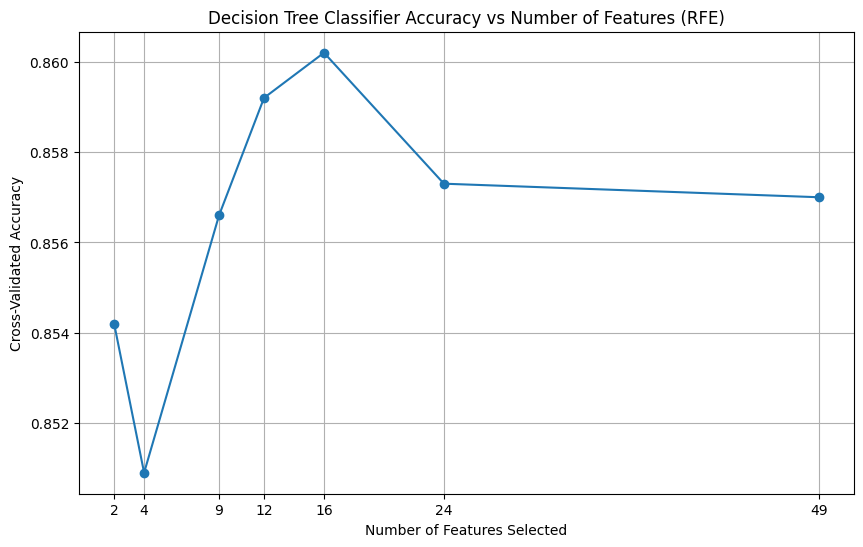


MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 88008
Number of features: 147

[FEATURE SELECTION] Using rfe to select 7 features...
  Selected features: ['price', 'product_name_lenght', 'product_description_lenght', 'product_weight_g', 'product_height_cm', 'payment_value_total', 'delivery_variance_days']

[MODELS] Will train 1 models:
  - decision_tree

[TRAINING] Starting model training with 5-fold cross-validation...
----------------------------------------------------------------------


Training decision_tree: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree          0.809        0.0039   0.8058  0.0035        0.8562

*** BEST MODEL: decision_tree (Accuracy: 0.809) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy
Number of Features: 7, Accuracy: 0.809

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 88008
Number of features: 147

[FEATURE SELECTION] Using rfe to select 14 features...
  Selected features: ['price', 'product_name_lenght', 'product_description_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_value_total', 'delivery_time_days', 'delivery_variance_days', 'processing_time_days', 'shipping_time_days', 'total_order_cost', 'freight

Training decision_tree: 100%|██████████| 1/1 [00:07<00:00,  7.35s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.7887        0.0022   0.7861  0.0019        0.8266

*** BEST MODEL: decision_tree (Accuracy: 0.7887) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy
Number of Features: 14, Accuracy: 0.7887

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 88008
Number of features: 147

[FEATURE SELECTION] Using rfe to select 29 features...
  Selected features: ['geolocation_lat', 'geolocation_lng', 'price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_value_total', 'payment_installments_max', 'delivery_time

Training decision_tree: 100%|██████████| 1/1 [00:11<00:00, 11.46s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.7905        0.0038   0.7864   0.004        0.8246

*** BEST MODEL: decision_tree (Accuracy: 0.7905) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy
Number of Features: 29, Accuracy: 0.7905

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 88008
Number of features: 147

[FEATURE SELECTION] Using rfe to select 36 features...
  Selected features: ['geolocation_lat', 'geolocation_lng', 'price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_value_total', 'payment_installments_max', 'delivery_time

Training decision_tree: 100%|██████████| 1/1 [00:11<00:00, 11.99s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.7998        0.0011   0.7962  0.0012        0.8344

*** BEST MODEL: decision_tree (Accuracy: 0.7998) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy
Number of Features: 36, Accuracy: 0.7998

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 88008
Number of features: 147

[FEATURE SELECTION] Using rfe to select 49 features...
  Selected features: ['geolocation_lat', 'geolocation_lng', 'price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_value_total', 'payment_installments_max', 'delivery_time

Training decision_tree: 100%|██████████| 1/1 [00:12<00:00, 12.41s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.8021        0.0007   0.7977   0.001        0.8361

*** BEST MODEL: decision_tree (Accuracy: 0.8021) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy
Number of Features: 49, Accuracy: 0.8021

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 88008
Number of features: 147

[FEATURE SELECTION] Using rfe to select 73 features...
  Selected features: ['geolocation_lat', 'geolocation_lng', 'price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_value_total', 'payment_installments_max', 'delivery_time

Training decision_tree: 100%|██████████| 1/1 [00:13<00:00, 13.49s/it]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree          0.799        0.0038   0.7926  0.0038        0.8273

*** BEST MODEL: decision_tree (Accuracy: 0.799) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy
Number of Features: 73, Accuracy: 0.799

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 88008
Number of features: 147

[FEATURE SELECTION] Using rfe to select 147 features...
  Selected features: ['geolocation_lat', 'geolocation_lng', 'price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_value_total', 'payment_installments_max', 'delivery_time_

Training decision_tree: 100%|██████████| 1/1 [00:16<00:00, 16.71s/it]


TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.7974        0.0027   0.7896  0.0037        0.8186

*** BEST MODEL: decision_tree (Accuracy: 0.7974) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy
Number of Features: 147, Accuracy: 0.7974


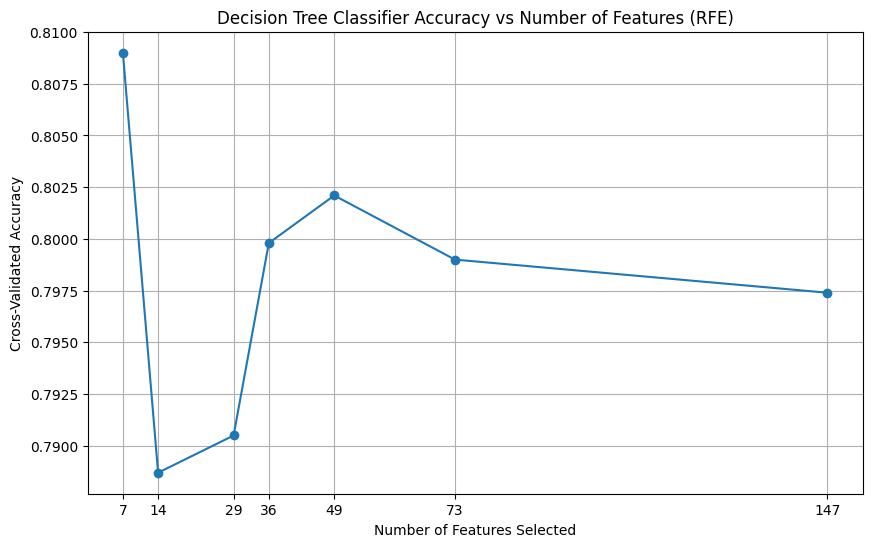


MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 5228
Number of features: 135

[FEATURE SELECTION] Using rfe to select 6 features...
  Selected features: ['Global_Sales', 'NA_Sales', 'PAL_Sales', 'Year', 'game_age_years', 'title_length']

[MODELS] Will train 1 models:
  - decision_tree

[TRAINING] Starting model training with 5-fold cross-validation...
----------------------------------------------------------------------


Training decision_tree: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.9216           0.0    0.884  0.0001        0.6553

*** BEST MODEL: decision_tree (Accuracy: 0.9216) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 20
    max_depth: 5
    criterion: entropy
Number of Features: 6, Accuracy: 0.9216

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 5228
Number of features: 135

[FEATURE SELECTION] Using rfe to select 13 features...


  Selected features: ['Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Year', 'game_age_years', 'title_length', 'is_sequel', 'Genre_Shooter', 'ESRB_Rating_M', 'ESRB_Rating_T', 'Publisher_grouped_Other']

[MODELS] Will train 1 models:
  - decision_tree

[TRAINING] Starting model training with 5-fold cross-validation...
----------------------------------------------------------------------


Training decision_tree: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.9216           0.0    0.884  0.0001        0.6521

*** BEST MODEL: decision_tree (Accuracy: 0.9216) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 10
    min_samples_leaf: 1
    max_depth: 3
    criterion: entropy
Number of Features: 13, Accuracy: 0.9216

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 5228
Number of features: 135

[FEATURE SELECTION] Using rfe to select 27 features...


  Selected features: ['Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Year', 'PAL_sales_reported', 'decade', 'game_age_years', 'title_length', 'is_sequel', 'Genre_Adventure', 'Genre_Misc', 'Genre_Platform', 'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Sports', 'ESRB_Rating_E10', 'ESRB_Rating_M', 'ESRB_Rating_T', 'ESRB_Rating_Unknown', 'Platform_GBA', 'Platform_PC', 'Publisher_grouped_Acclaim Entertainment', 'Publisher_grouped_Other', 'Developer_grouped_Other']

[MODELS] Will train 1 models:
  - decision_tree

[TRAINING] Starting model training with 5-fold cross-validation...
----------------------------------------------------------------------


Training decision_tree: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.9078        0.0053   0.8914  0.0072        0.6411

*** BEST MODEL: decision_tree (Accuracy: 0.9078) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy
Number of Features: 27, Accuracy: 0.9078

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 5228
Number of features: 135

[FEATURE SELECTION] Using rfe to select 33 features...
  Selected features: ['Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Year', 'PAL_sales_reported', 'decade', 'game_age_years', 'title_length', 'is_sequel', 'Genre_Adventure', 'Genre_Misc', 'Genre_Platform', 'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation', 'Genre

Training decision_tree: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.9063        0.0046   0.8875   0.007        0.6328

*** BEST MODEL: decision_tree (Accuracy: 0.9063) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy
Number of Features: 33, Accuracy: 0.9063

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 5228
Number of features: 135

[FEATURE SELECTION] Using rfe to select 45 features...
  Selected features: ['Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Year', 'NA_sales_reported', 'PAL_sales_reported', 'JP_sales_reported', 'decade', 'game_age_years', 'title_length', 'is_sequel', 'Genre_Adventure', 'Genre_Fighting', 'Genre_Misc', 'Genre_Platform', 'Genre_Racing', 'Genr

Training decision_tree: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.9118        0.0044   0.8881  0.0036        0.6651

*** BEST MODEL: decision_tree (Accuracy: 0.9118) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 20
    min_samples_leaf: 1
    max_depth: 10
    criterion: entropy
Number of Features: 45, Accuracy: 0.9118

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 5228
Number of features: 135

[FEATURE SELECTION] Using rfe to select 67 features...
  Selected features: ['Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Year', 'Global_sales_reported', 'NA_sales_reported', 'PAL_sales_reported', 'JP_sales_reported', 'Other_sales_reported', 'decade', 'game_age_years', 'title_length', 'is_sequel', 'Genre_Adventure', 'Genre_Fighting', 'Gen

Training decision_tree: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.9139        0.0031   0.8873  0.0031        0.6567

*** BEST MODEL: decision_tree (Accuracy: 0.9139) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 50
    min_samples_leaf: 2
    max_depth: 20
    criterion: gini
Number of Features: 67, Accuracy: 0.9139

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 5228
Number of features: 135

[FEATURE SELECTION] Using rfe to select 135 features...
  Selected features: ['Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Year', 'Global_sales_reported', 'NA_sales_reported', 'PAL_sales_reported', 'JP_sales_reported', 'Other_sales_reported', 'decade', 'game_age_years', 'title_length', 'is_sequel', 'Genre_Action-Adventure', 'Genre_Adventure'

Training decision_tree: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
        model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
decision_tree         0.9145        0.0037   0.8871  0.0034        0.6528

*** BEST MODEL: decision_tree (Accuracy: 0.9145) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 50
    min_samples_leaf: 2
    max_depth: 20
    criterion: gini
Number of Features: 135, Accuracy: 0.9145


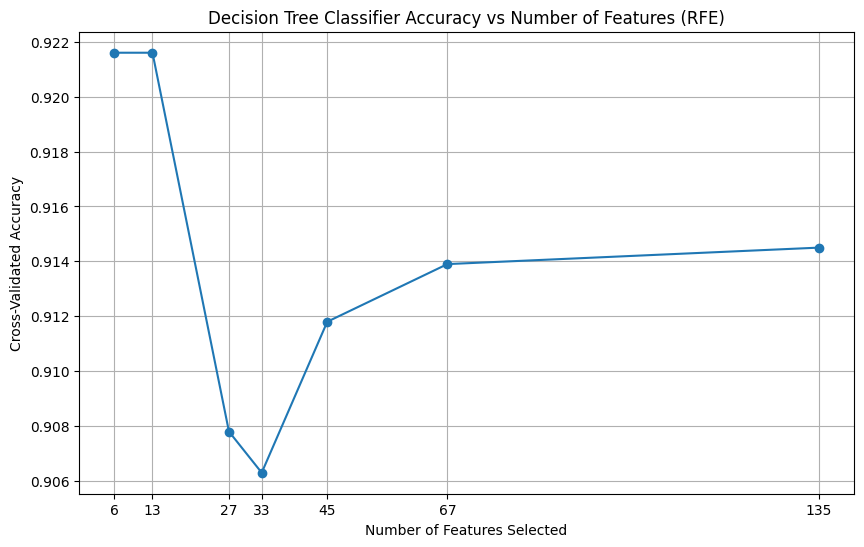

In [12]:
import matplotlib.pyplot as plt
accuracies = []
num_features_list = []
for n in [len(X_train_steam_clf.columns)//20, len(X_train_steam_clf.columns)//10, len(X_train_steam_clf.columns)//5, len(X_train_steam_clf.columns)//4, len(X_train_steam_clf.columns)//3, len(X_train_steam_clf.columns)//2, len(X_train_steam_clf.columns)]:
    results_steam_clf = train_and_evaluate_models(
        X_train=X_train_steam_clf,
        y_train=y_train_steam_clf,
        task_type="classification",
        models_to_run=["decision_tree"],
        do_hyperparameter_tuning=True,
        n_random_search_iterations=10,
        do_feature_selection=True,
        feature_selection_method="rfe",
        n_features_to_select=n,
        random_state=42,
        verbose=True
    )
    accuracy = results_steam_clf["summary"]["accuracy_mean"].sort_values(ascending=False)[0]
    accuracies.append(accuracy)
    num_features_list.append(n)
    print(f"Number of Features: {n}, Accuracy: {accuracy}")

best_num_features_steam = num_features_list[np.argmax(accuracies)]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracies, marker='o')
plt.title('Decision Tree Classifier Accuracy vs Number of Features (RFE)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(num_features_list)
plt.grid()
plt.show()

accuracies = []
num_features_list = []
for n in [len(X_train_olist_clf.columns)//20, len(X_train_olist_clf.columns)//10, len(X_train_olist_clf.columns)//5, len(X_train_olist_clf.columns)//4, len(X_train_olist_clf.columns)//3, len(X_train_olist_clf.columns)//2, len(X_train_olist_clf.columns)]:
    results_olist_clf = train_and_evaluate_models(
        X_train=X_train_olist_clf,
        y_train=y_train_olist_clf,
        task_type="classification",
        models_to_run=["decision_tree"],
        do_hyperparameter_tuning=True,
        n_random_search_iterations=10,
        do_feature_selection=True,
        feature_selection_method="rfe",
        n_features_to_select=n,
        random_state=42,
        verbose=True
    )
    accuracy = results_olist_clf["summary"]["accuracy_mean"].sort_values(ascending=False)[0]
    accuracies.append(accuracy)
    num_features_list.append(n)
    print(f"Number of Features: {n}, Accuracy: {accuracy}")

best_num_features_olist = num_features_list[np.argmax(accuracies)]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracies, marker='o')
plt.title('Decision Tree Classifier Accuracy vs Number of Features (RFE)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(num_features_list)
plt.grid()
plt.show()


accuracies = []
num_features_list = []
for n in [len(X_train_sales_clf.columns)//20, len(X_train_sales_clf.columns)//10, len(X_train_sales_clf.columns)//5, len(X_train_sales_clf.columns)//4, len(X_train_sales_clf.columns)//3, len(X_train_sales_clf.columns)//2, len(X_train_sales_clf.columns)]:
    results_sales_clf = train_and_evaluate_models(
        X_train=X_train_sales_clf,
        y_train=y_train_sales_clf,
        task_type="classification",
        models_to_run=["decision_tree"],
        do_hyperparameter_tuning=True,
        n_random_search_iterations=10,
        do_feature_selection=True,
        feature_selection_method="rfe",
        n_features_to_select=n,
        random_state=42,
        verbose=True
    )
    accuracy = results_sales_clf["summary"]["accuracy_mean"].sort_values(ascending=False)[0]
    accuracies.append(accuracy)
    num_features_list.append(n)
    print(f"Number of Features: {n}, Accuracy: {accuracy}")

best_num_features_sales = num_features_list[np.argmax(accuracies)]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracies, marker='o')
plt.title('Decision Tree Classifier Accuracy vs Number of Features (RFE)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(num_features_list)
plt.grid()
plt.show()

In [13]:
print("STEAM DATASET RESULTS")
results_steam_clf = train_and_evaluate_models(
    X_train=X_train_steam_clf,
    y_train=y_train_steam_clf,
    task_type="classification",
    models_to_run="all",
    do_hyperparameter_tuning=True,
    n_random_search_iterations=20,
    do_feature_selection=True,
    feature_selection_method="rfe",
    n_features_to_select=best_num_features_steam,
    random_state=42,
    verbose=True
)
results_steam_reg = train_and_evaluate_models(
    X_train=X_train_steam_reg,
    y_train=y_train_steam_reg,
    task_type="regression",
    models_to_run="all",
    do_hyperparameter_tuning=True,
    n_random_search_iterations=20,
    do_feature_selection=True,
    feature_selection_method="rfe",
    n_features_to_select=best_num_features_steam,
    random_state=42,
    verbose=True
)
results_steam_clu = train_and_evaluate_models(
    X_train=X_train_steam_clf,
    y_train=None,
    task_type="unsupervised",
    models_to_run=["kmeans"],
    do_hyperparameter_tuning=True,
    n_random_search_iterations=20,
    do_feature_selection=False,
    feature_selection_method="rfe",
    n_features_to_select=best_num_features_steam,
    random_state=42,
    verbose=True
)
print("\n" + "=" * 70 + "\n")
print("OLIST DATASET RESULTS")
results_olist_clf = train_and_evaluate_models(
    X_train=X_train_olist_clf,
    y_train=y_train_olist_clf,
    task_type="classification",
    models_to_run="all",
    do_hyperparameter_tuning=True,
    n_random_search_iterations=20,
    do_feature_selection=True,
    feature_selection_method="rfe",
    n_features_to_select=best_num_features_olist,
    random_state=42,
    verbose=True
)
results_olist_reg = train_and_evaluate_models(
    X_train=X_train_olist_reg,
    y_train=y_train_olist_reg,
    task_type="regression",
    models_to_run="all",
    do_hyperparameter_tuning=True,
    n_random_search_iterations=20,
    do_feature_selection=True,
    feature_selection_method="rfe",
    n_features_to_select=best_num_features_olist,
    random_state=42,
    verbose=True
)
results_olist_clu = train_and_evaluate_models(
    X_train=X_train_olist_clf,
    y_train=None,
    task_type="unsupervised",
    models_to_run=["kmeans"],
    do_hyperparameter_tuning=True,
    n_random_search_iterations=20,
    do_feature_selection=False,
    feature_selection_method="rfe",
    n_features_to_select=best_num_features_olist,
    random_state=42,
    verbose=True
)
print("\n" + "=" * 70 + "\n")
print("SALES DATASET RESULTS")
results_sales_clf = train_and_evaluate_models(
    X_train=X_train_sales_clf,
    y_train=y_train_sales_clf,
    task_type="classification",
    models_to_run="all",
    do_hyperparameter_tuning=True,
    n_random_search_iterations=20,
    do_feature_selection=True,
    feature_selection_method="rfe",
    n_features_to_select=best_num_features_sales,
    random_state=42,
    verbose=True
)
results_sales_reg = train_and_evaluate_models(
    X_train=X_train_sales_reg,
    y_train=y_train_sales_reg,
    task_type="regression",
    models_to_run="all",
    do_hyperparameter_tuning=True,
    n_random_search_iterations=20,
    do_feature_selection=True,
    feature_selection_method="rfe",
    n_features_to_select=best_num_features_sales,
    random_state=42,
    verbose=True
)
results_sales_clu = train_and_evaluate_models(
    X_train=X_train_sales_clf,
    y_train=None,
    task_type="unsupervised",
    models_to_run=["kmeans"],
    do_hyperparameter_tuning=True,
    n_random_search_iterations=20,
    do_feature_selection=False,
    feature_selection_method="rfe",
    n_features_to_select=best_num_features_sales,
    random_state=42,
    verbose=True
)

STEAM DATASET RESULTS

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 30088
Number of features: 49

[FEATURE SELECTION] Using rfe to select 16 features...
  Selected features: ['user_reviews', 'price_final', 'price_original', 'hours_total', 'helpful_total', 'funny_total', 'unique_users', 'hours_mean', 'helpful_mean', 'funny_mean', 'release_month', 'game_age_days', 'tag_count', 'description_length', 'description_word_count', 'title_length']

[MODELS] Will train 6 models:
  - decision_tree
  - random_forest
  - gradient_boosting
  - logistic_regression
  - knn
  - neural_network

[TRAINING] Starting model training with 5-fold cross-validation...
----------------------------------------------------------------------


Training neural_network: 100%|██████████| 6/6 [09:39<00:00, 96.52s/it]      



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
              model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
      random_forest         0.8705        0.0012   0.8232  0.0025        0.7366
     neural_network         0.8694        0.0007   0.8123  0.0015        0.7304
logistic_regression         0.8691        0.0005   0.8100  0.0012        0.6958
  gradient_boosting         0.8589        0.0029   0.8293  0.0043        0.7169
      decision_tree         0.8537        0.0042   0.8238  0.0032        0.6619
                knn         0.8536        0.0019   0.8175  0.0013        0.6228

*** BEST MODEL: random_forest (Accuracy: 0.8705) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 20
    min_samples_leaf: 20
    max_depth: None
    criterion: gini

  random_forest:
    n_estimators: 100
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: 

Training neural_network: 100%|██████████| 8/8 [04:02<00:00, 30.25s/it]   



TRAINING COMPLETE - SUMMARY

REGRESSION RESULTS (sorted by R²):
----------------------------------------------------------------------
            model  r2_mean  r2_std  mse_mean  mae_mean
gradient_boosting   0.2786  0.0126  232.6461   11.7516
    random_forest   0.2773  0.0092  233.1081   11.8082
   neural_network   0.2517  0.0150  241.3207   12.0030
    decision_tree   0.1805  0.0077  264.3303   12.6487
              knn   0.1541  0.0072  272.8700   12.8174
            lasso   0.1256  0.0134  282.0783   13.1455
            ridge   0.1255  0.0136  282.1193   13.1459
linear_regression      NaN     NaN       NaN       NaN

*** BEST MODEL: gradient_boosting (R²: 0.2786) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 10
    min_samples_leaf: 10
    max_depth: 5

  random_forest:
    n_estimators: 200
    min_samples_split: 2
    min_samples_leaf: 5
    max_features: log2
    max_depth: None

  gradient_boosting:
    subsample: 0.9
    n_estimators: 50
    min_sampl

Training kmeans: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]



TRAINING COMPLETE - SUMMARY

CLUSTERING RESULTS:
----------------------------------------------------------------------
 model  n_clusters  silhouette_score  calinski_harabasz  davies_bouldin
kmeans           8            0.0636          1378.6257          2.2035

Note: Higher silhouette and Calinski-Harabasz scores are better.
      Lower Davies-Bouldin score is better.


OLIST DATASET RESULTS

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 88008
Number of features: 147

[FEATURE SELECTION] Using rfe to select 7 features...
  Selected features: ['price', 'product_name_lenght', 'product_description_lenght', 'product_weight_g', 'product_height_cm', 'payment_value_total', 'delivery_variance_days']

[MODELS] Will train 6 models:
  - decision_tree
  - random_forest
  - gradient_boosting
  - logistic_regression
  - knn
  - neural_network

[TRAINING] Starting model training with 5-fold cross-validation...
--------------------------------------------------

Training neural_network: 100%|██████████| 6/6 [33:48<00:00, 338.13s/it]     



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
              model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
  gradient_boosting         0.9180        0.0022   0.9161  0.0023        0.9642
      random_forest         0.8887        0.0015   0.8842  0.0017        0.9485
                knn         0.8449        0.0016   0.8436  0.0017        0.8785
      decision_tree         0.8090        0.0039   0.8058  0.0035        0.8562
     neural_network         0.7821        0.0063   0.7689  0.0106        0.8109
logistic_regression         0.6917        0.0011   0.5836  0.0017        0.5921

*** BEST MODEL: gradient_boosting (Accuracy: 0.918) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 10
    max_depth: 20
    criterion: entropy

  random_forest:
    n_estimators: 100
    min_samples_split: 5
    min_samples_leaf: 2
    max_feature

Training neural_network: 100%|██████████| 8/8 [11:49<00:00, 88.66s/it]    



TRAINING COMPLETE - SUMMARY

REGRESSION RESULTS (sorted by R²):
----------------------------------------------------------------------
            model  r2_mean  r2_std  mse_mean  mae_mean
    random_forest   0.2766  0.0028    0.4846    0.4701
              knn   0.2278  0.0055    0.5174    0.4738
gradient_boosting   0.2205  0.0055    0.5223    0.5007
   neural_network   0.0859  0.0024    0.6124    0.5556
    decision_tree   0.0828  0.0043    0.6144    0.5527
            ridge   0.0586  0.0020    0.6307    0.5596
            lasso   0.0586  0.0019    0.6307    0.5596
linear_regression      NaN     NaN       NaN       NaN

*** BEST MODEL: random_forest (R²: 0.2766) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 10
    min_samples_leaf: 5
    max_depth: 10

  random_forest:
    n_estimators: 100
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: log2
    max_depth: None

  gradient_boosting:
    subsample: 0.8
    n_estimators: 200
    min_samples_

Training kmeans: 100%|██████████| 1/1 [00:31<00:00, 31.26s/it]



TRAINING COMPLETE - SUMMARY

CLUSTERING RESULTS:
----------------------------------------------------------------------
 model  n_clusters  silhouette_score  calinski_harabasz  davies_bouldin
kmeans           8            0.0678          5097.5816          2.4618

Note: Higher silhouette and Calinski-Harabasz scores are better.
      Lower Davies-Bouldin score is better.


SALES DATASET RESULTS

MODEL TRAINING AND EVALUATION PIPELINE
Task Type: CLASSIFICATION
Training samples: 5228
Number of features: 135

[FEATURE SELECTION] Using rfe to select 6 features...
  Selected features: ['Global_Sales', 'NA_Sales', 'PAL_Sales', 'Year', 'game_age_years', 'title_length']

[MODELS] Will train 6 models:
  - decision_tree
  - random_forest
  - gradient_boosting
  - logistic_regression
  - knn
  - neural_network

[TRAINING] Starting model training with 5-fold cross-validation...
----------------------------------------------------------------------


Training neural_network: 100%|██████████| 6/6 [00:22<00:00,  3.69s/it]     



TRAINING COMPLETE - SUMMARY

CLASSIFICATION RESULTS (sorted by accuracy):
----------------------------------------------------------------------
              model  accuracy_mean  accuracy_std  f1_mean  f1_std  roc_auc_mean
      decision_tree         0.9216        0.0000    0.884  0.0001        0.6553
  gradient_boosting         0.9216        0.0000    0.884  0.0001        0.6649
logistic_regression         0.9216        0.0000    0.884  0.0001        0.5876
                knn         0.9216        0.0000    0.884  0.0001        0.6071
     neural_network         0.9216        0.0000    0.884  0.0001        0.5345
      random_forest         0.9202        0.0014    0.884  0.0010        0.6409

*** BEST MODEL: decision_tree (Accuracy: 0.9216) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 5
    min_samples_leaf: 20
    max_depth: 5
    criterion: entropy

  random_forest:
    n_estimators: 50
    min_samples_split: 5
    min_samples_leaf: 2
    max_features: lo

Training neural_network: 100%|██████████| 8/8 [00:15<00:00,  1.91s/it]   



TRAINING COMPLETE - SUMMARY

REGRESSION RESULTS (sorted by R²):
----------------------------------------------------------------------
            model  r2_mean  r2_std  mse_mean  mae_mean
    random_forest   0.1359  0.0123    1.8372    1.0527
gradient_boosting   0.1337  0.0119    1.8419    1.0535
    decision_tree   0.1012  0.0153    1.9113    1.0800
   neural_network   0.0757  0.0118    1.9659    1.0945
              knn   0.0565  0.0111    2.0062    1.0965
            ridge   0.0404  0.0025    2.0411    1.1195
            lasso   0.0404  0.0025    2.0410    1.1195
linear_regression      NaN     NaN       NaN       NaN

*** BEST MODEL: random_forest (R²: 0.1359) ***

[BEST HYPERPARAMETERS]

  decision_tree:
    min_samples_split: 10
    min_samples_leaf: 10
    max_depth: 5

  random_forest:
    n_estimators: 100
    min_samples_split: 10
    min_samples_leaf: 1
    max_features: sqrt
    max_depth: 10

  gradient_boosting:
    subsample: 0.9
    n_estimators: 100
    min_samples_s

Training kmeans: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


TRAINING COMPLETE - SUMMARY

CLUSTERING RESULTS:
----------------------------------------------------------------------
 model  n_clusters  silhouette_score  calinski_harabasz  davies_bouldin
kmeans           8            0.1587           798.3308          1.7547

Note: Higher silhouette and Calinski-Harabasz scores are better.
      Lower Davies-Bouldin score is better.


In [14]:
results_summary = {
    "steam": {
        "classification": results_steam_clf,
        "regression": results_steam_reg,
        "clustering": results_steam_clu
    },
    "olist": {
        "classification": results_olist_clf,
        "regression": results_olist_reg,
        "clustering": results_olist_clu
    },
    "sales": {
        "classification": results_sales_clf,
        "regression": results_sales_reg,
        "clustering": results_sales_clu
    }
}
print(results_summary)

{'steam': {'classification': {'models': {'decision_tree': DecisionTreeClassifier(min_samples_leaf=20, min_samples_split=20,
                       random_state=42), 'random_forest': RandomForestClassifier(max_depth=15, max_features=None, n_jobs=-1,
                       random_state=42), 'gradient_boosting': GradientBoostingClassifier(learning_rate=0.2, max_depth=20, min_samples_leaf=5,
                           min_samples_split=50, random_state=42,
                           subsample=0.5), 'logistic_regression': LogisticRegression(C=1, max_iter=5000, random_state=42), 'knn': KNeighborsClassifier(metric='manhattan', weights='distance'), 'neural_network': MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100),
              learning_rate='adaptive', max_iter=5000, random_state=42)}, 'cv_scores': {'decision_tree': {'accuracy_mean': 0.8537, 'accuracy_std': 0.0042, 'precision_mean': 0.8098, 'precision_std': 0.0046, 'recall_mean': 0.8537, 'recall_std': 0.0042, 'f1_mean': 0.823